In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def compute_and_save_jeans_deviation(base_dir, suite_name):
    """
    Compute the Jeans equation deviation δ_J(r) for each halo and save to CSV.
    NOTE: G=1 !!!
    """
    density_dir = os.path.join(base_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(base_dir, "output", suite_name, "velocity_profiles")
    mass_dir = os.path.join(base_dir, "output", suite_name, "mass_profiles")
    out_dir = os.path.join(base_dir, "output", suite_name, "jeans_deviation")
    os.makedirs(out_dir, exist_ok=True)

    halo_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])

    for f in halo_files:
        halo_id = f.split("_")[1]
        try:
            df_rho = pd.read_csv(os.path.join(density_dir, f))
            df_vel = pd.read_csv(os.path.join(velocity_dir, f))
            df_mass = pd.read_csv(os.path.join(mass_dir, f))

            r = df_rho["r_scaled"].values
            rho = df_rho["rho_scaled"].values
            sigma_r2 = df_vel["sigma_rad_scaled"].values ** 2
            beta = df_vel["beta"].values
            m = df_mass["m_scaled"].values

            # Compute pressure gradient d/dr (rho * sigma_r^2)
            P_r = rho * sigma_r2
            dPdr = np.gradient(P_r, r)

            # Compute dPhi/dr = G * M(<r) / r^2
            dPhidr = m / (r ** 2)

            # Compute numerator and denominator
            numer = dPdr + 2 * beta * P_r / r + rho * dPhidr
            denom = rho * dPhidr

            delta_J = np.abs(numer / denom)

            df_out = pd.DataFrame({
                "halo_id": int(halo_id),
                "r_scaled": r,
                "delta_J": delta_J
            })
            df_out.to_csv(os.path.join(out_dir, f"halo_{int(halo_id):03d}_profile.csv"), index=False)
            print(f"[Saved] Jeans deviation for halo {halo_id}")
        except Exception as e:
            print(f"[Warning] Failed to compute Jeans deviation for halo {halo_id}: {e}")

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
compute_and_save_jeans_deviation(base_dir, "SymphonyCluster")

In [ ]:
import os
import pandas as pd
import numpy as np

def compute_delta_J_tot(r, delta_J):
    mask = r <= 1.0
    r_cut = r[mask]
    delta_J_cut = delta_J[mask]
    delta_J_tot = np.trapezoid(delta_J_cut, r_cut)
    return delta_J_tot

def compute_and_save_delta_J_tot_per_suite(base_dir, suite_names, jeans_dir_name="jeans_deviation"):
    for suite in suite_names:
        results = []
        jeans_dir = os.path.join(base_dir, "output", suite, jeans_dir_name)
        files = sorted([f for f in os.listdir(jeans_dir) if f.endswith(".csv")])

        for f in files:
            halo_id = int(f.split("_")[1])
            df = pd.read_csv(os.path.join(jeans_dir, f))
            r = df["r_scaled"].values
            delta_J = df["delta_J"].values

            delta_J_tot = compute_delta_J_tot(r, delta_J)

            results.append({
                "halo_id": halo_id,
                "delta_J_tot": delta_J_tot
            })

        df_summary = pd.DataFrame(results)

        output_csv = os.path.join(base_dir, "output", suite, f"jeans_deviation_total.csv")
        df_summary.to_csv(output_csv, index=False)
        print(f"[Saved] Jeans deviation total summary for {suite} to {output_csv}")

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

compute_and_save_delta_J_tot_per_suite(base_dir, suite_names)

Spearman ρ = 0.082, p = 2.13e-01


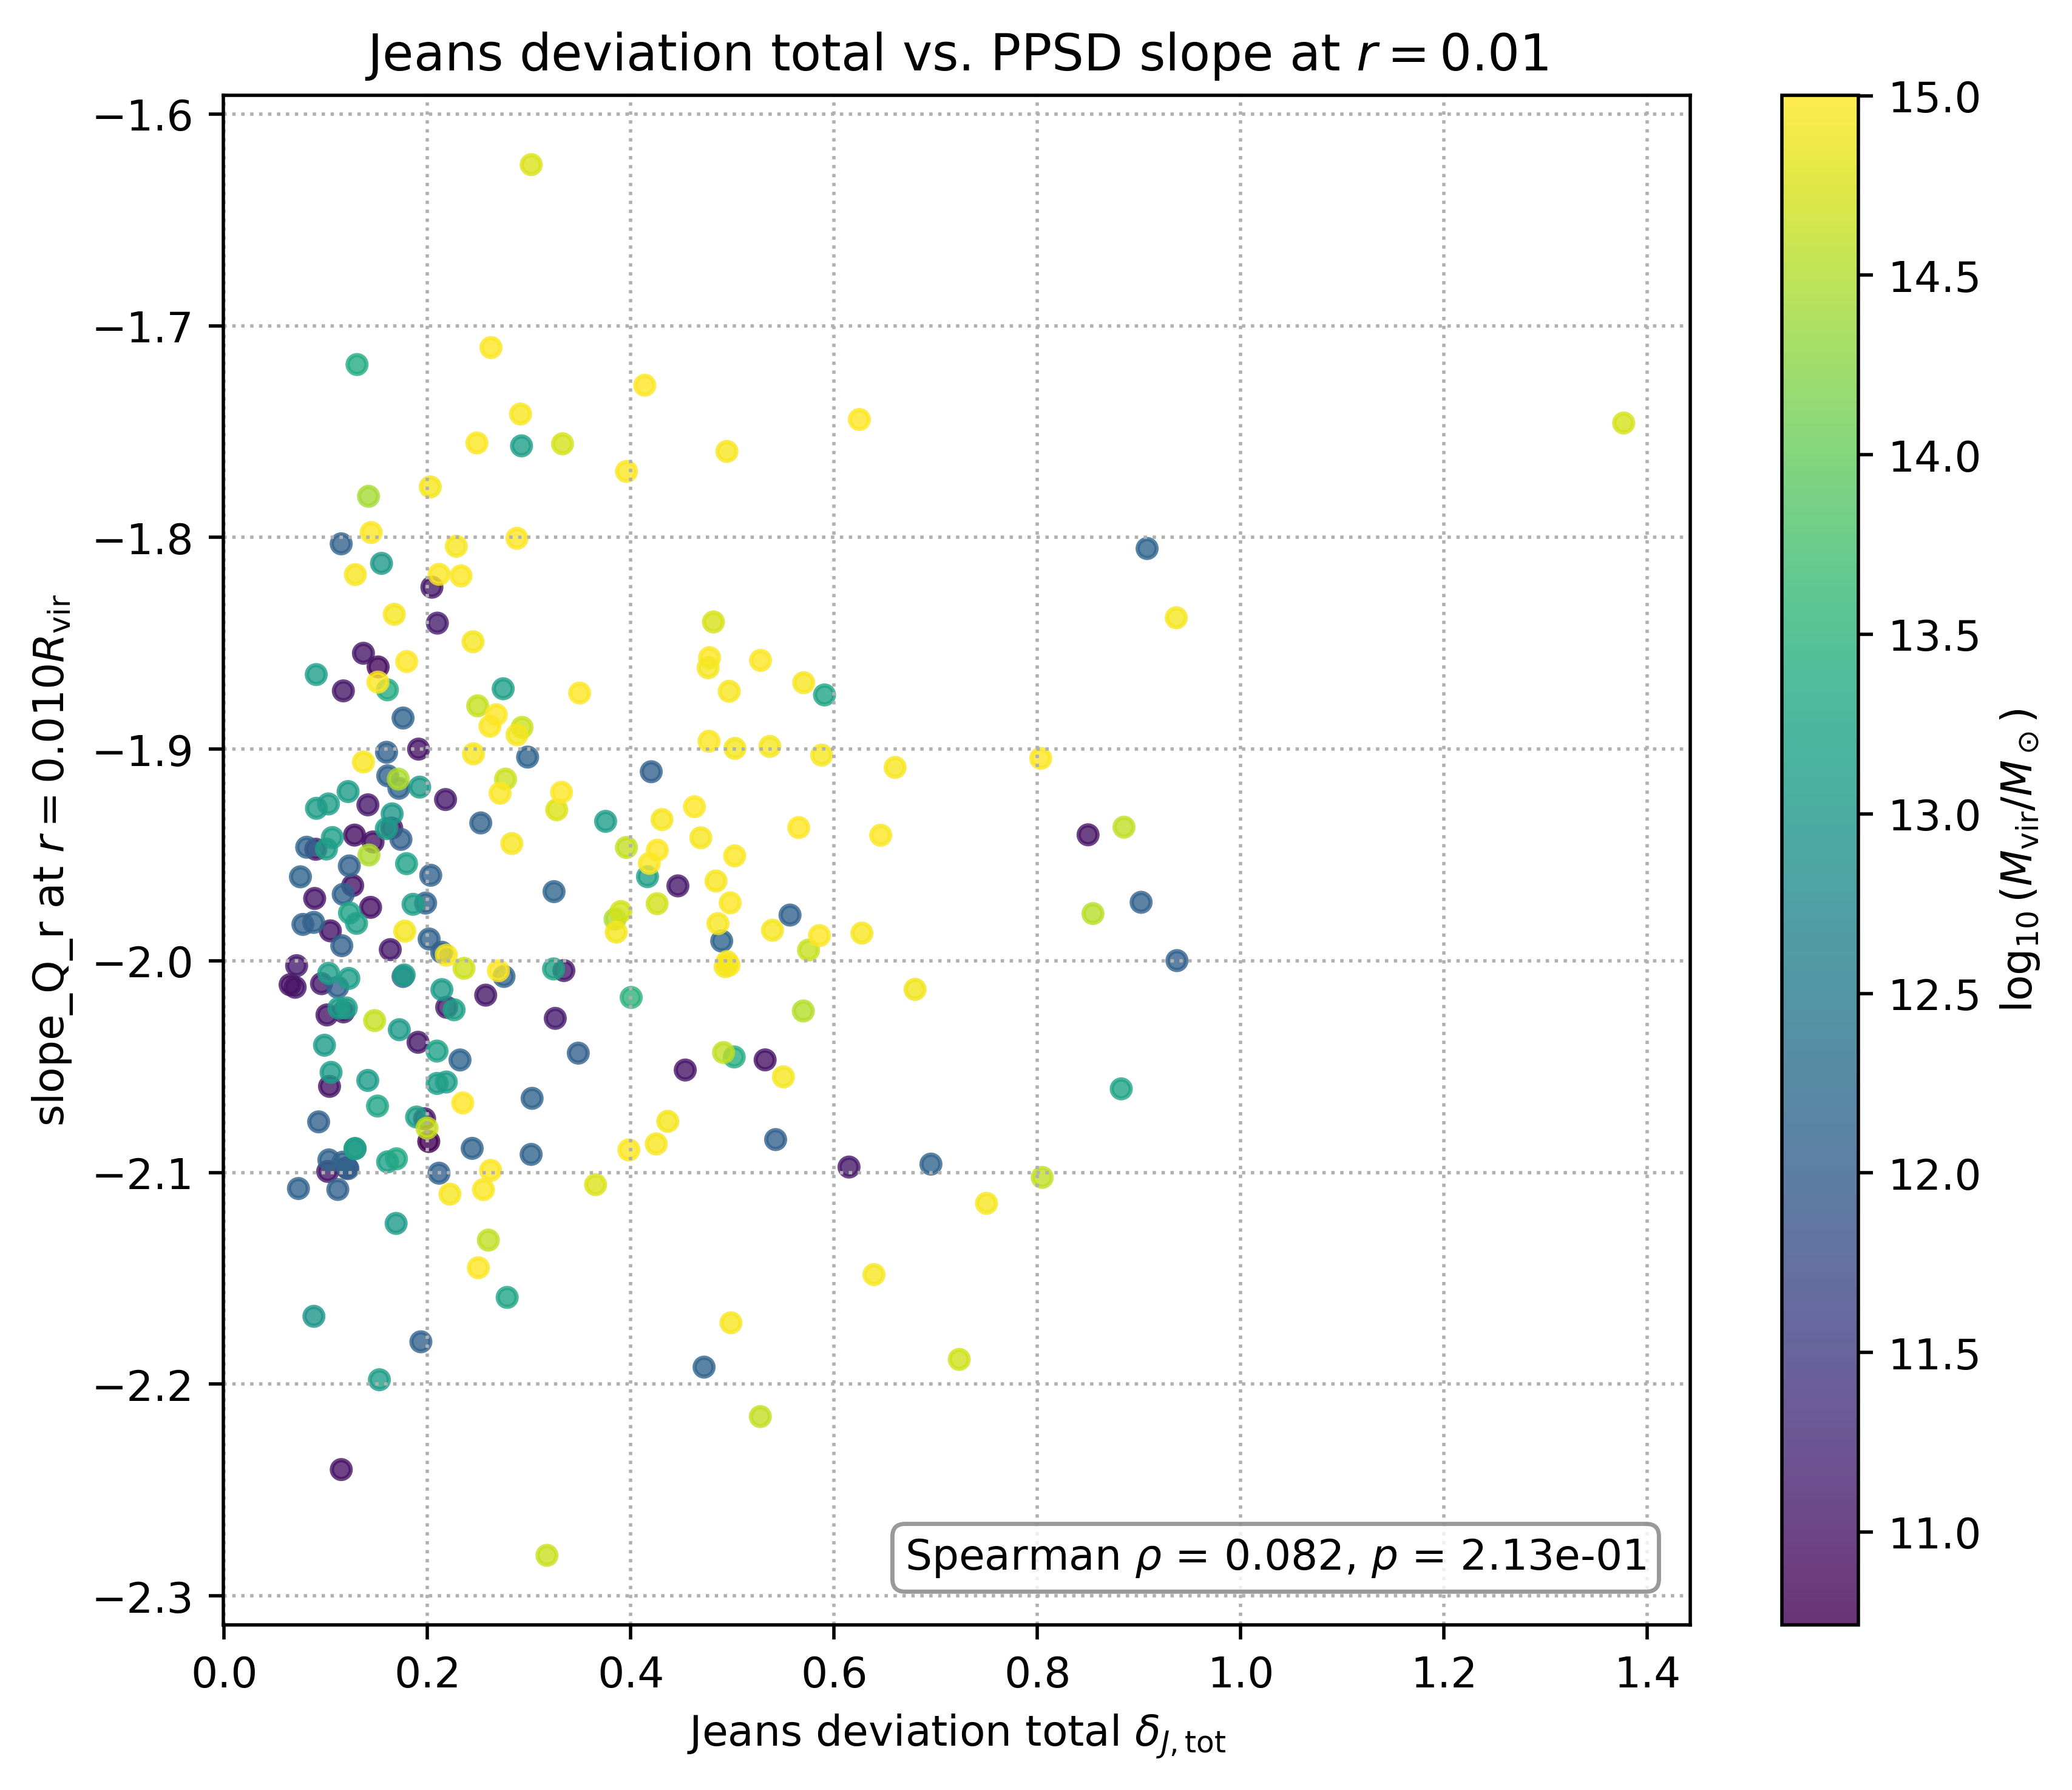

Spearman ρ = -0.555, p = 2.27e-20


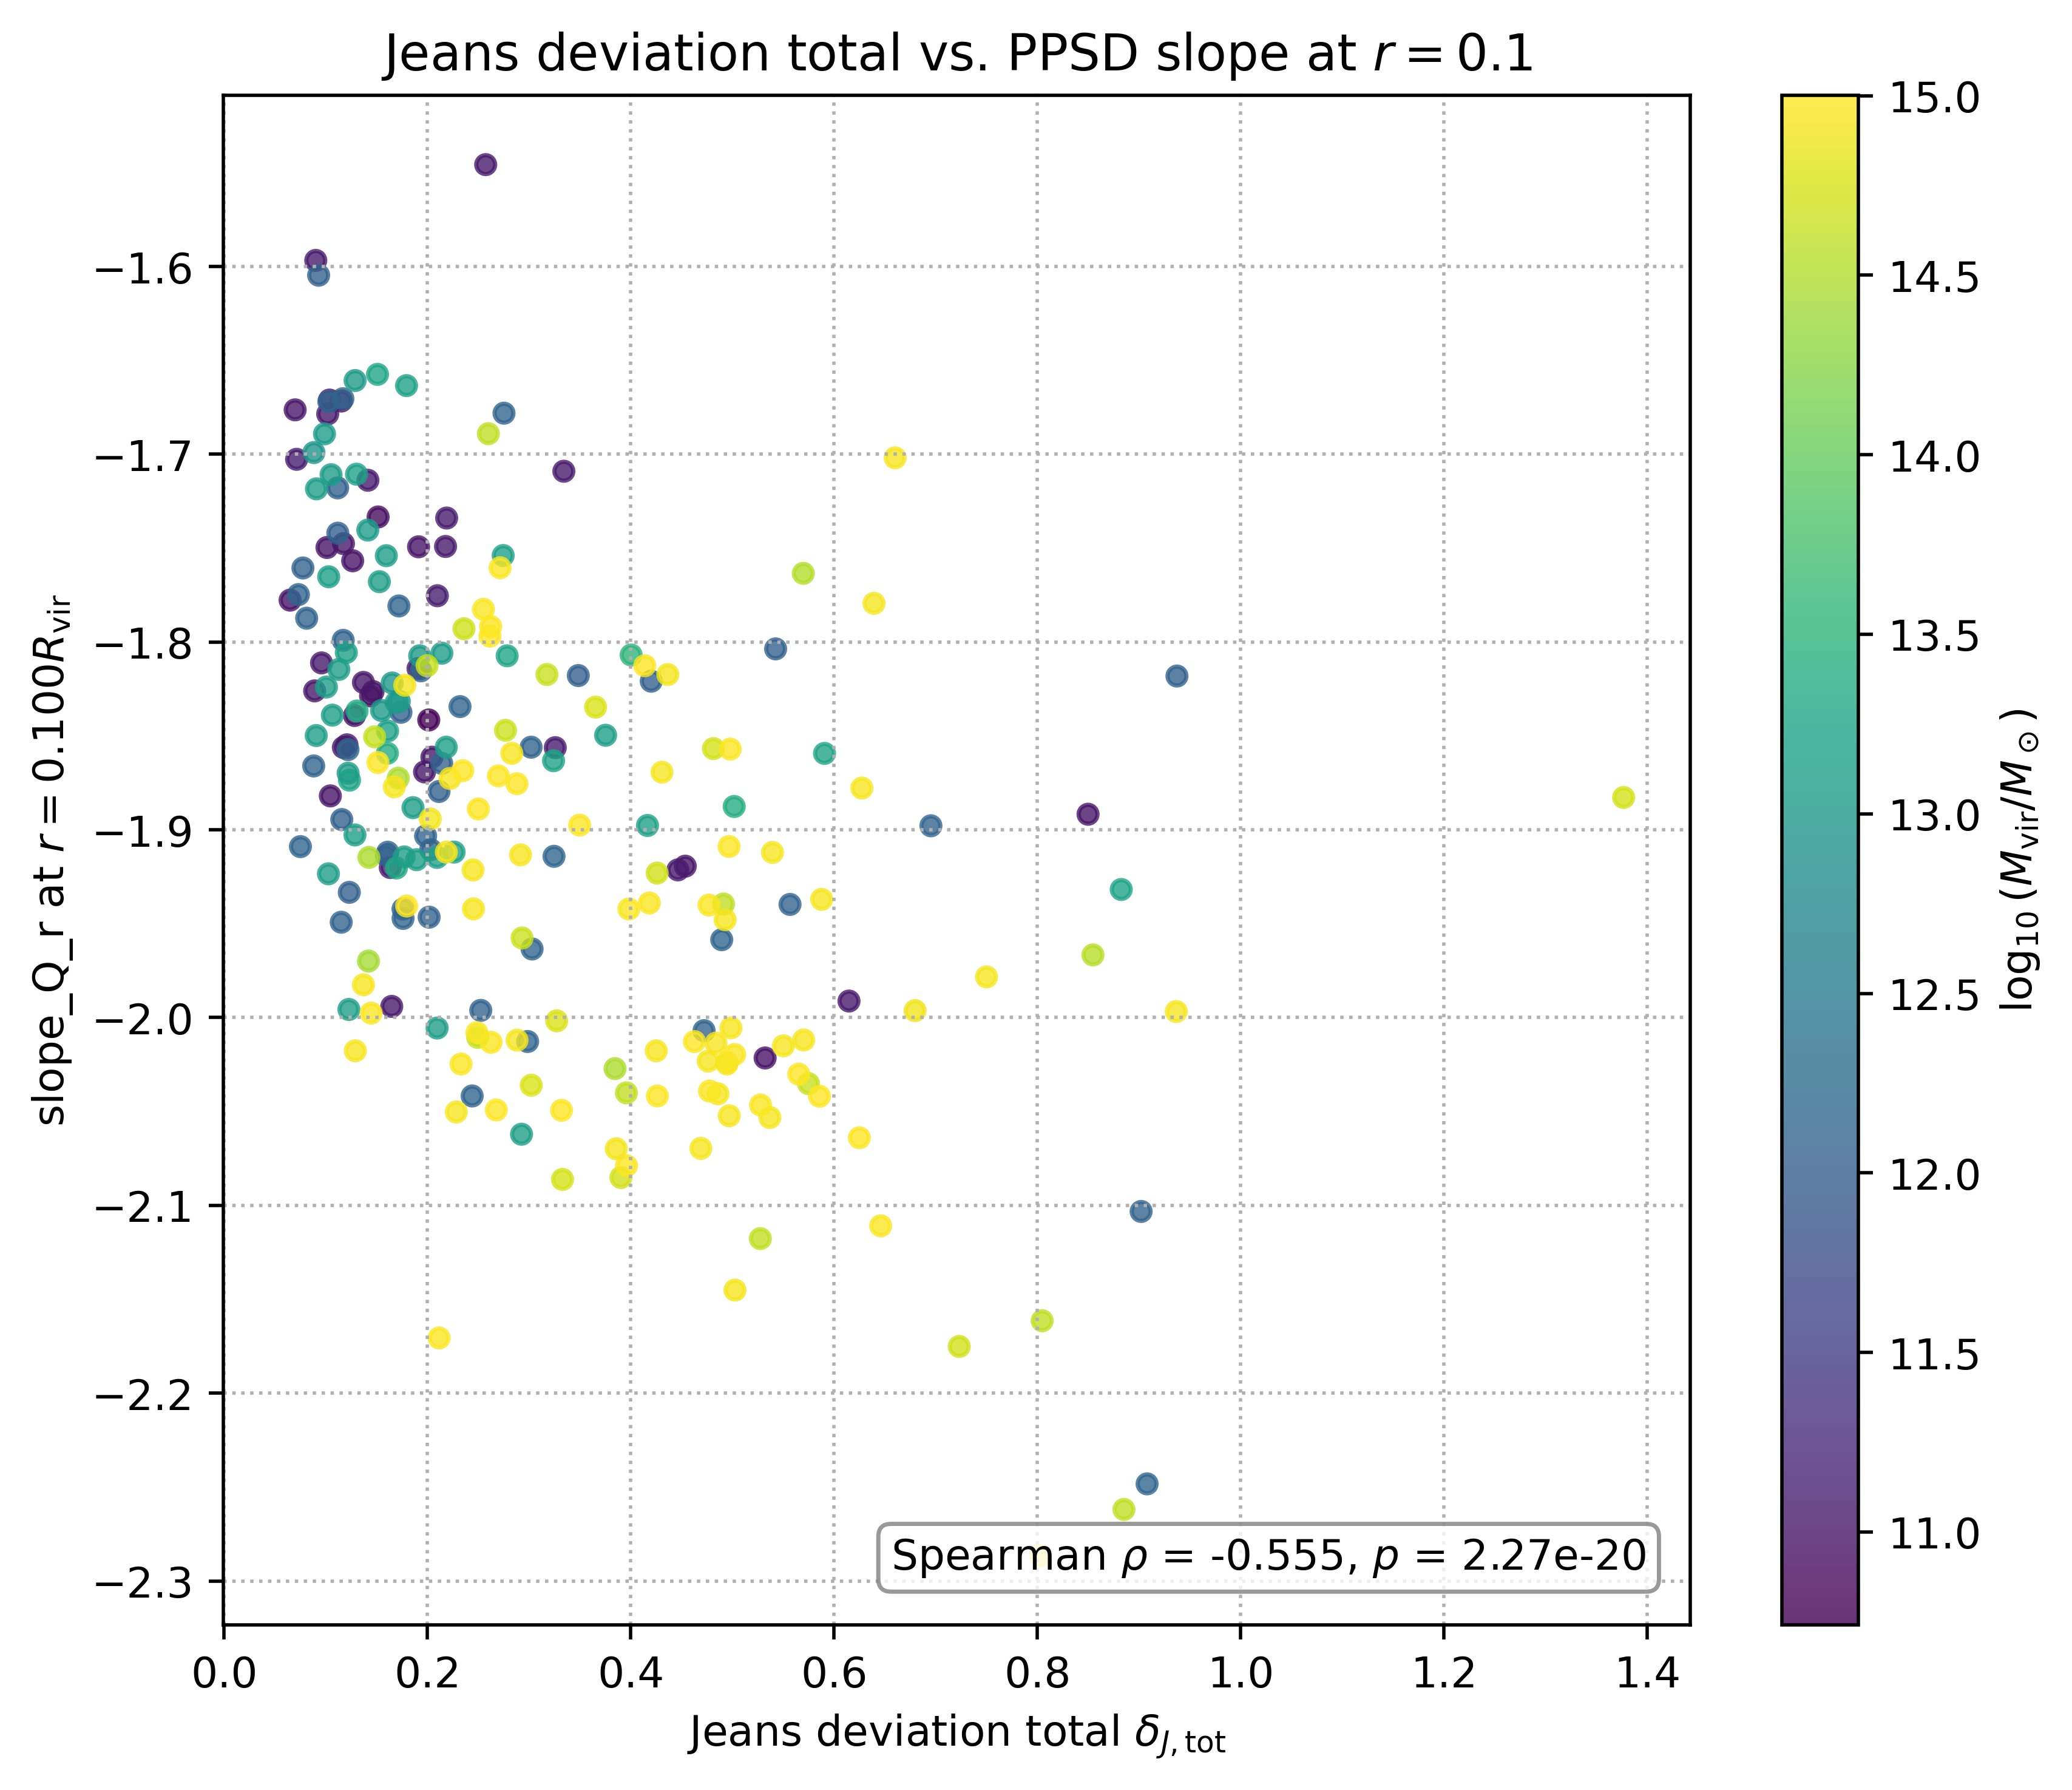

Spearman ρ = -0.152, p = 2.00e-02


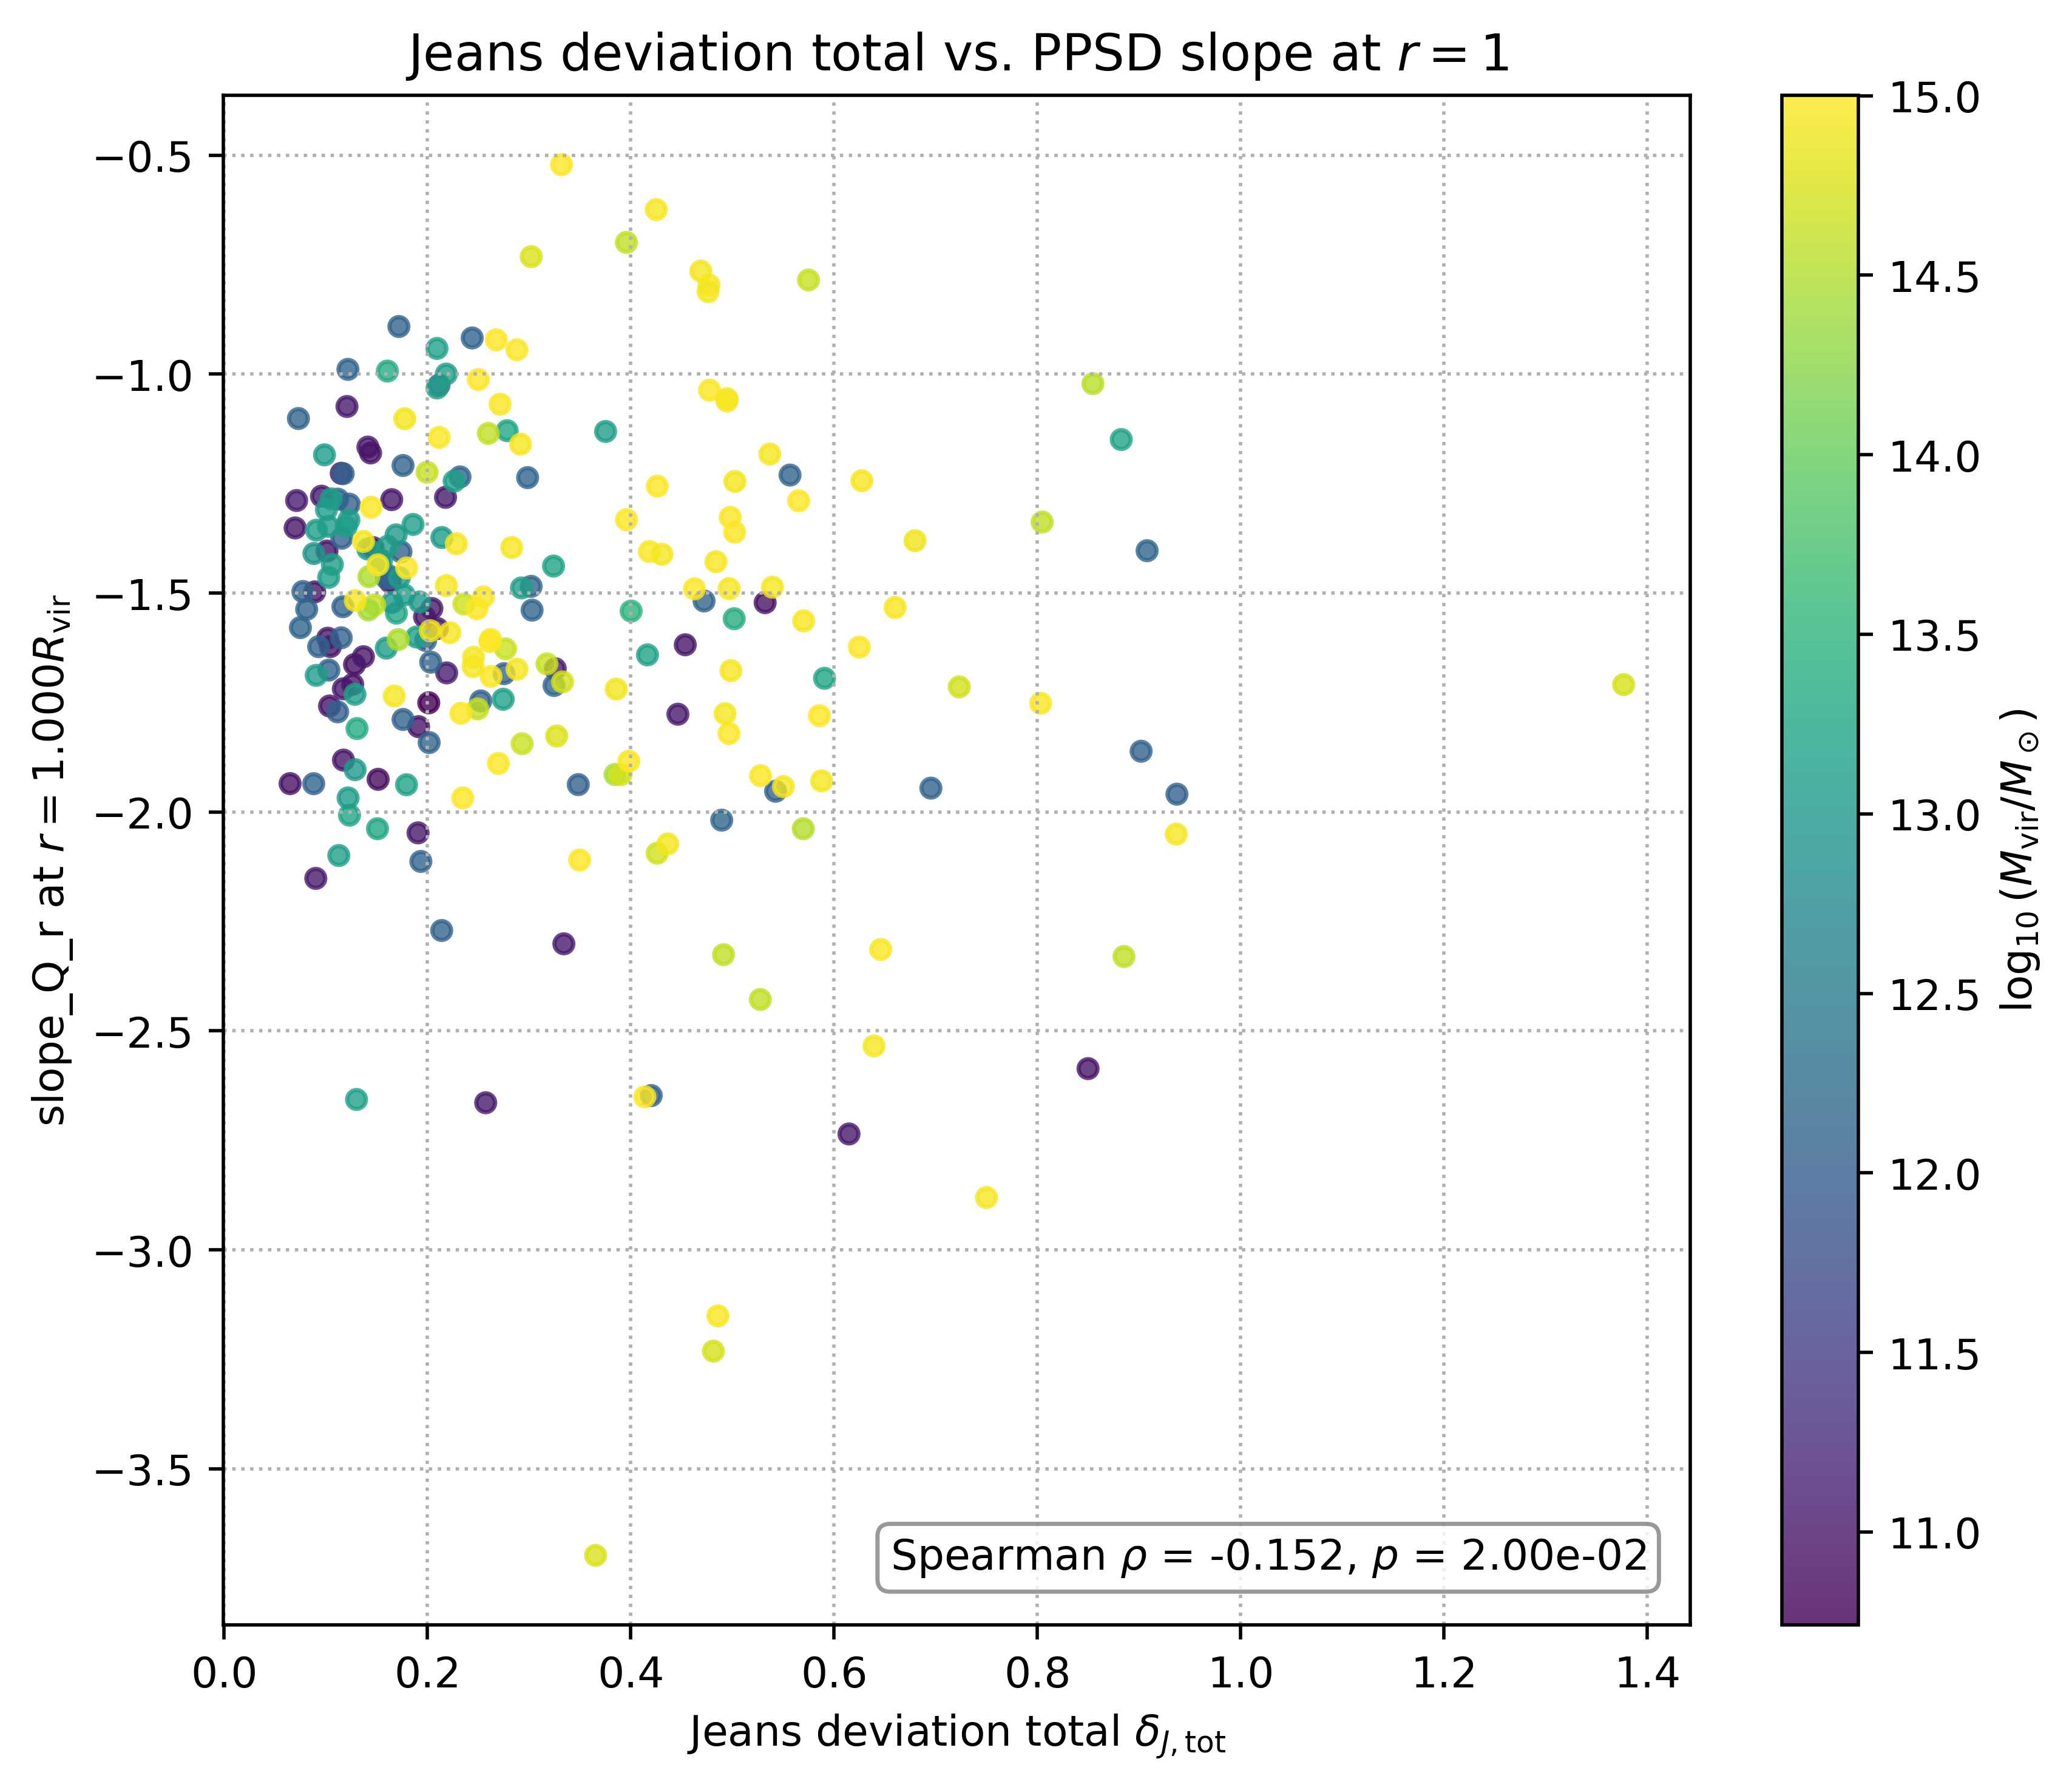

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def quantify_slope_jeans_total_relation(base_dir, suite_names, r_target=0.01, slope_var="slope_Q_r"):
    slope_vals, jeans_tot_vals, mass_vals = [], [], []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        jeans_tot_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_jeans_tot = pd.read_csv(jeans_tot_path)
        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(df_mass["halo_id"], df_mass["mvir"]))
        jeans_tot_dict = dict(zip(df_jeans_tot["halo_id"], df_jeans_tot["delta_J_tot"]))

        for f in sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")]):
            try:
                halo_id = int(f.split("_")[1])
                slope_df = pd.read_csv(os.path.join(slope_dir, f))

                r_slope = slope_df["r_scaled"].values
                slope = slope_df[slope_var].values

                interp_slope = interp1d(r_slope, slope, bounds_error=False, fill_value=np.nan)
                slope_val = float(interp_slope(r_target))

                jeans_val = jeans_tot_dict.get(halo_id, np.nan)
                mass = mass_dict.get(halo_id, np.nan)

                if np.isfinite(slope_val) and np.isfinite(jeans_val):
                    slope_vals.append(slope_val)
                    jeans_tot_vals.append(jeans_val)
                    mass_vals.append(mass)
            except Exception as e:
                print(f"[Warning] Failed to process halo {f} in {suite}: {e}")

    slope_vals = np.array(slope_vals)
    jeans_tot_vals = np.array(jeans_tot_vals)
    log_mass = np.log10(np.array(mass_vals))

    if len(slope_vals) < 2:
        print("[Warning] Not enough data.")
        return

    spearman_r, spearman_p = spearmanr(jeans_tot_vals, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(jeans_tot_vals, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8)
    cbar = plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir} / M_\odot)$")
    plt.xlabel(r"Jeans deviation total $\delta_{J, \mathrm{tot}}$")
    plt.ylabel(fr"{slope_var} at $r = {r_target:.3f} R_{{\rm vir}}$")
    plt.title(f"Jeans deviation total vs. PPSD slope at $r = {r_target}$")
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}, $p$ = {spearman_p:.2e}",
    ))
    plt.text(0.97, 0.03, textstr, transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

for r in [0.01, 0.1, 1]:
    quantify_slope_jeans_total_relation(
        base_dir, suite_names,
        r_target=r,
        slope_var="slope_Q_r"
    )


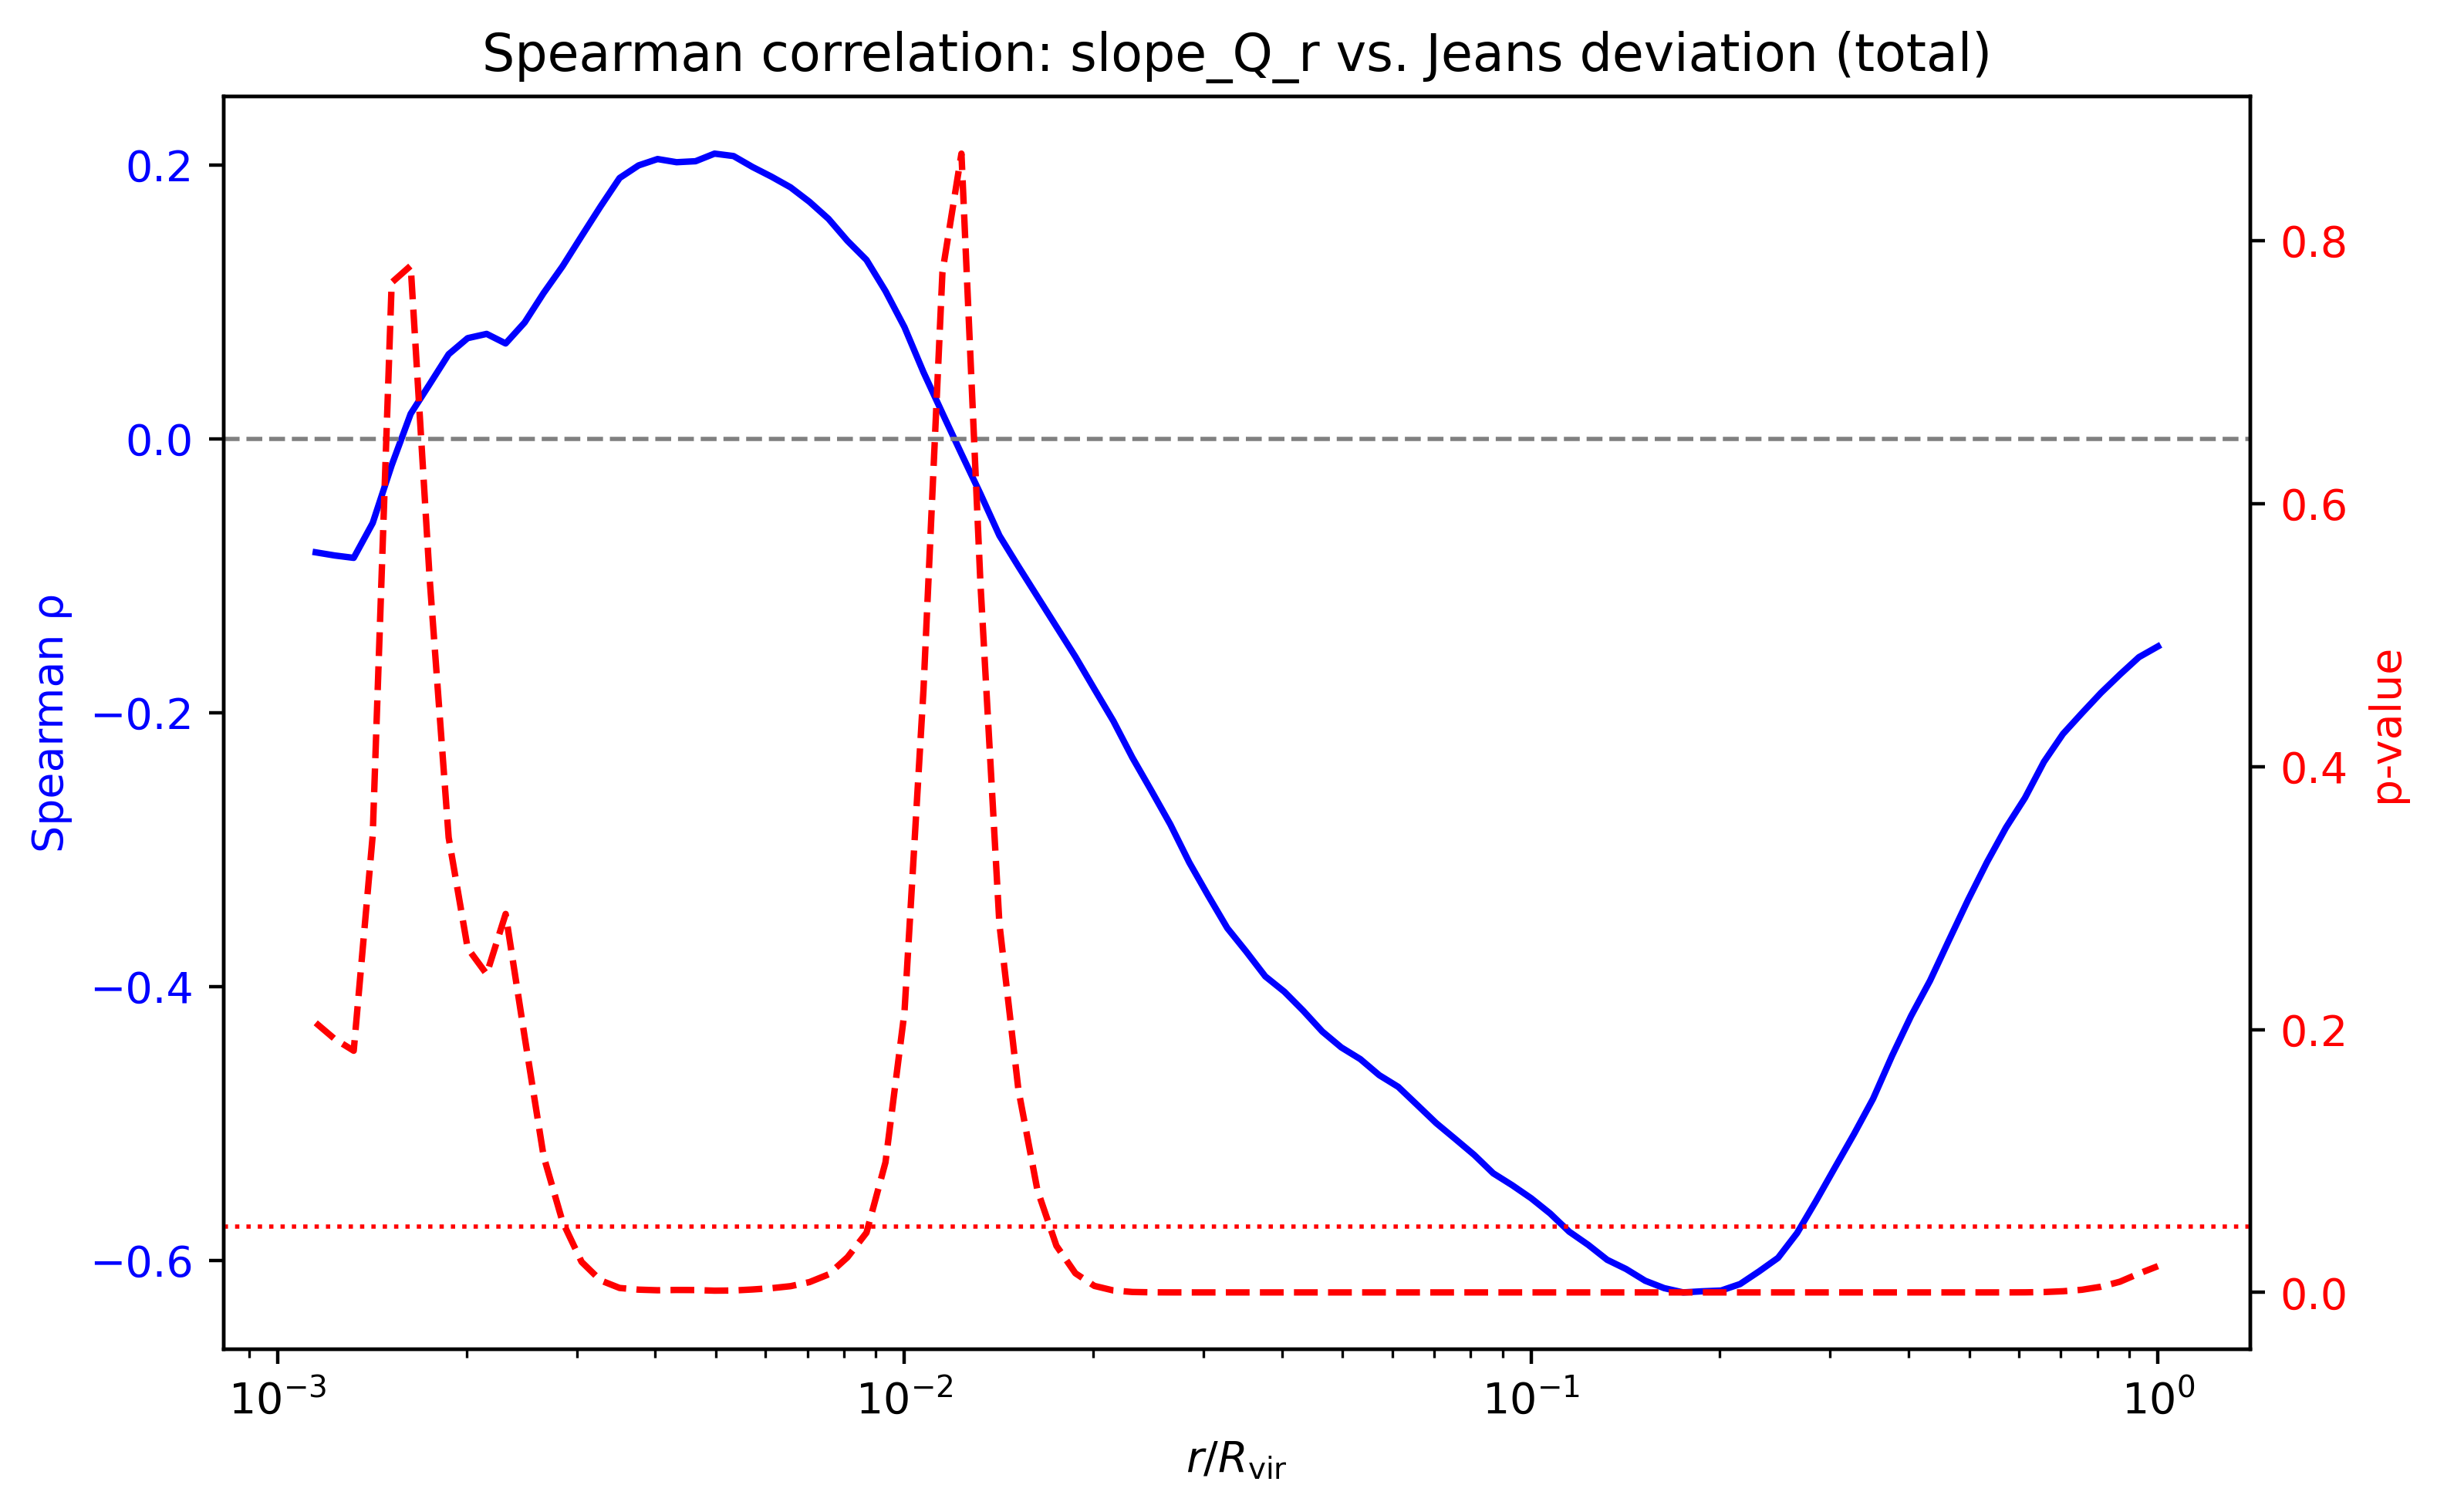

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def plot_spearman_slope_vs_jeans_vs_r(base_dir, suite_names, slope_var="slope_Q_r", n_r=50):
    r_grid = np.logspace(-3, 0, n_r)  
    # Storage for all halo data
    slope_profiles_all = []
    jeans_vals_all = []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        jeans_tot_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")

        # Load Jeans deviation
        df_jeans = pd.read_csv(jeans_tot_path)
        jeans_dict = dict(zip(df_jeans["halo_id"], df_jeans["delta_J_tot"]))

        for f in sorted(os.listdir(slope_dir)):
            if not f.endswith(".csv"):
                continue
            try:
                halo_id = int(f.split("_")[1])
                slope_df = pd.read_csv(os.path.join(slope_dir, f))
                r_vals = slope_df["r_scaled"].values
                slope_vals = slope_df[slope_var].values

                if len(r_vals) < 5 or not np.all(np.isfinite(slope_vals)):
                    continue

                slope_interp = interp1d(r_vals, slope_vals, bounds_error=False, fill_value=np.nan)
                slope_grid = slope_interp(r_grid)

                delta_J = jeans_dict.get(halo_id, np.nan)
                if not np.isfinite(delta_J):
                    continue

                slope_profiles_all.append(slope_grid)
                jeans_vals_all.append(delta_J)

            except Exception as e:
                print(f"[Warning] Failed on {f} in {suite}: {e}")

    slope_profiles_all = np.array(slope_profiles_all)  # shape: (N_halos, n_r)
    jeans_vals_all = np.array(jeans_vals_all)  # shape: (N_halos,)

    # Now compute Spearman rho and p-value at each radius
    rho_vals, p_vals = [], []
    for i in range(n_r):
        slope_at_r = slope_profiles_all[:, i]
        valid = np.isfinite(slope_at_r) & np.isfinite(jeans_vals_all)
        if np.sum(valid) >= 5:
            rho, p = spearmanr(jeans_vals_all[valid], slope_at_r[valid])
        else:
            rho, p = np.nan, np.nan
        rho_vals.append(rho)
        p_vals.append(p)

    # Plotting
    fig, ax1 = plt.subplots(figsize=(8, 5), dpi=400)

    ax1.plot(r_grid, rho_vals, label="Spearman ρ", color="blue")
    ax1.set_xlabel(r"$r / R_{\rm vir}$")
    ax1.set_ylabel("Spearman ρ", color="blue")
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.axhline(0, color="gray", linestyle="--", linewidth=1)

    ax2 = ax1.twinx()
    ax2.plot(r_grid, p_vals, label="p-value", color="red", linestyle="--")
    ax2.set_ylabel("p-value", color="red")
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.axhline(0.05, color="red", linestyle=":", linewidth=1)

    ax1.set_xscale("log")
    ax1.set_title(f"Spearman correlation: {slope_var} vs. Jeans deviation (total)")
    fig.tight_layout()
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

plot_spearman_slope_vs_jeans_vs_r(
    base_dir, suite_names,
    slope_var="slope_Q_r",
    n_r=100
)

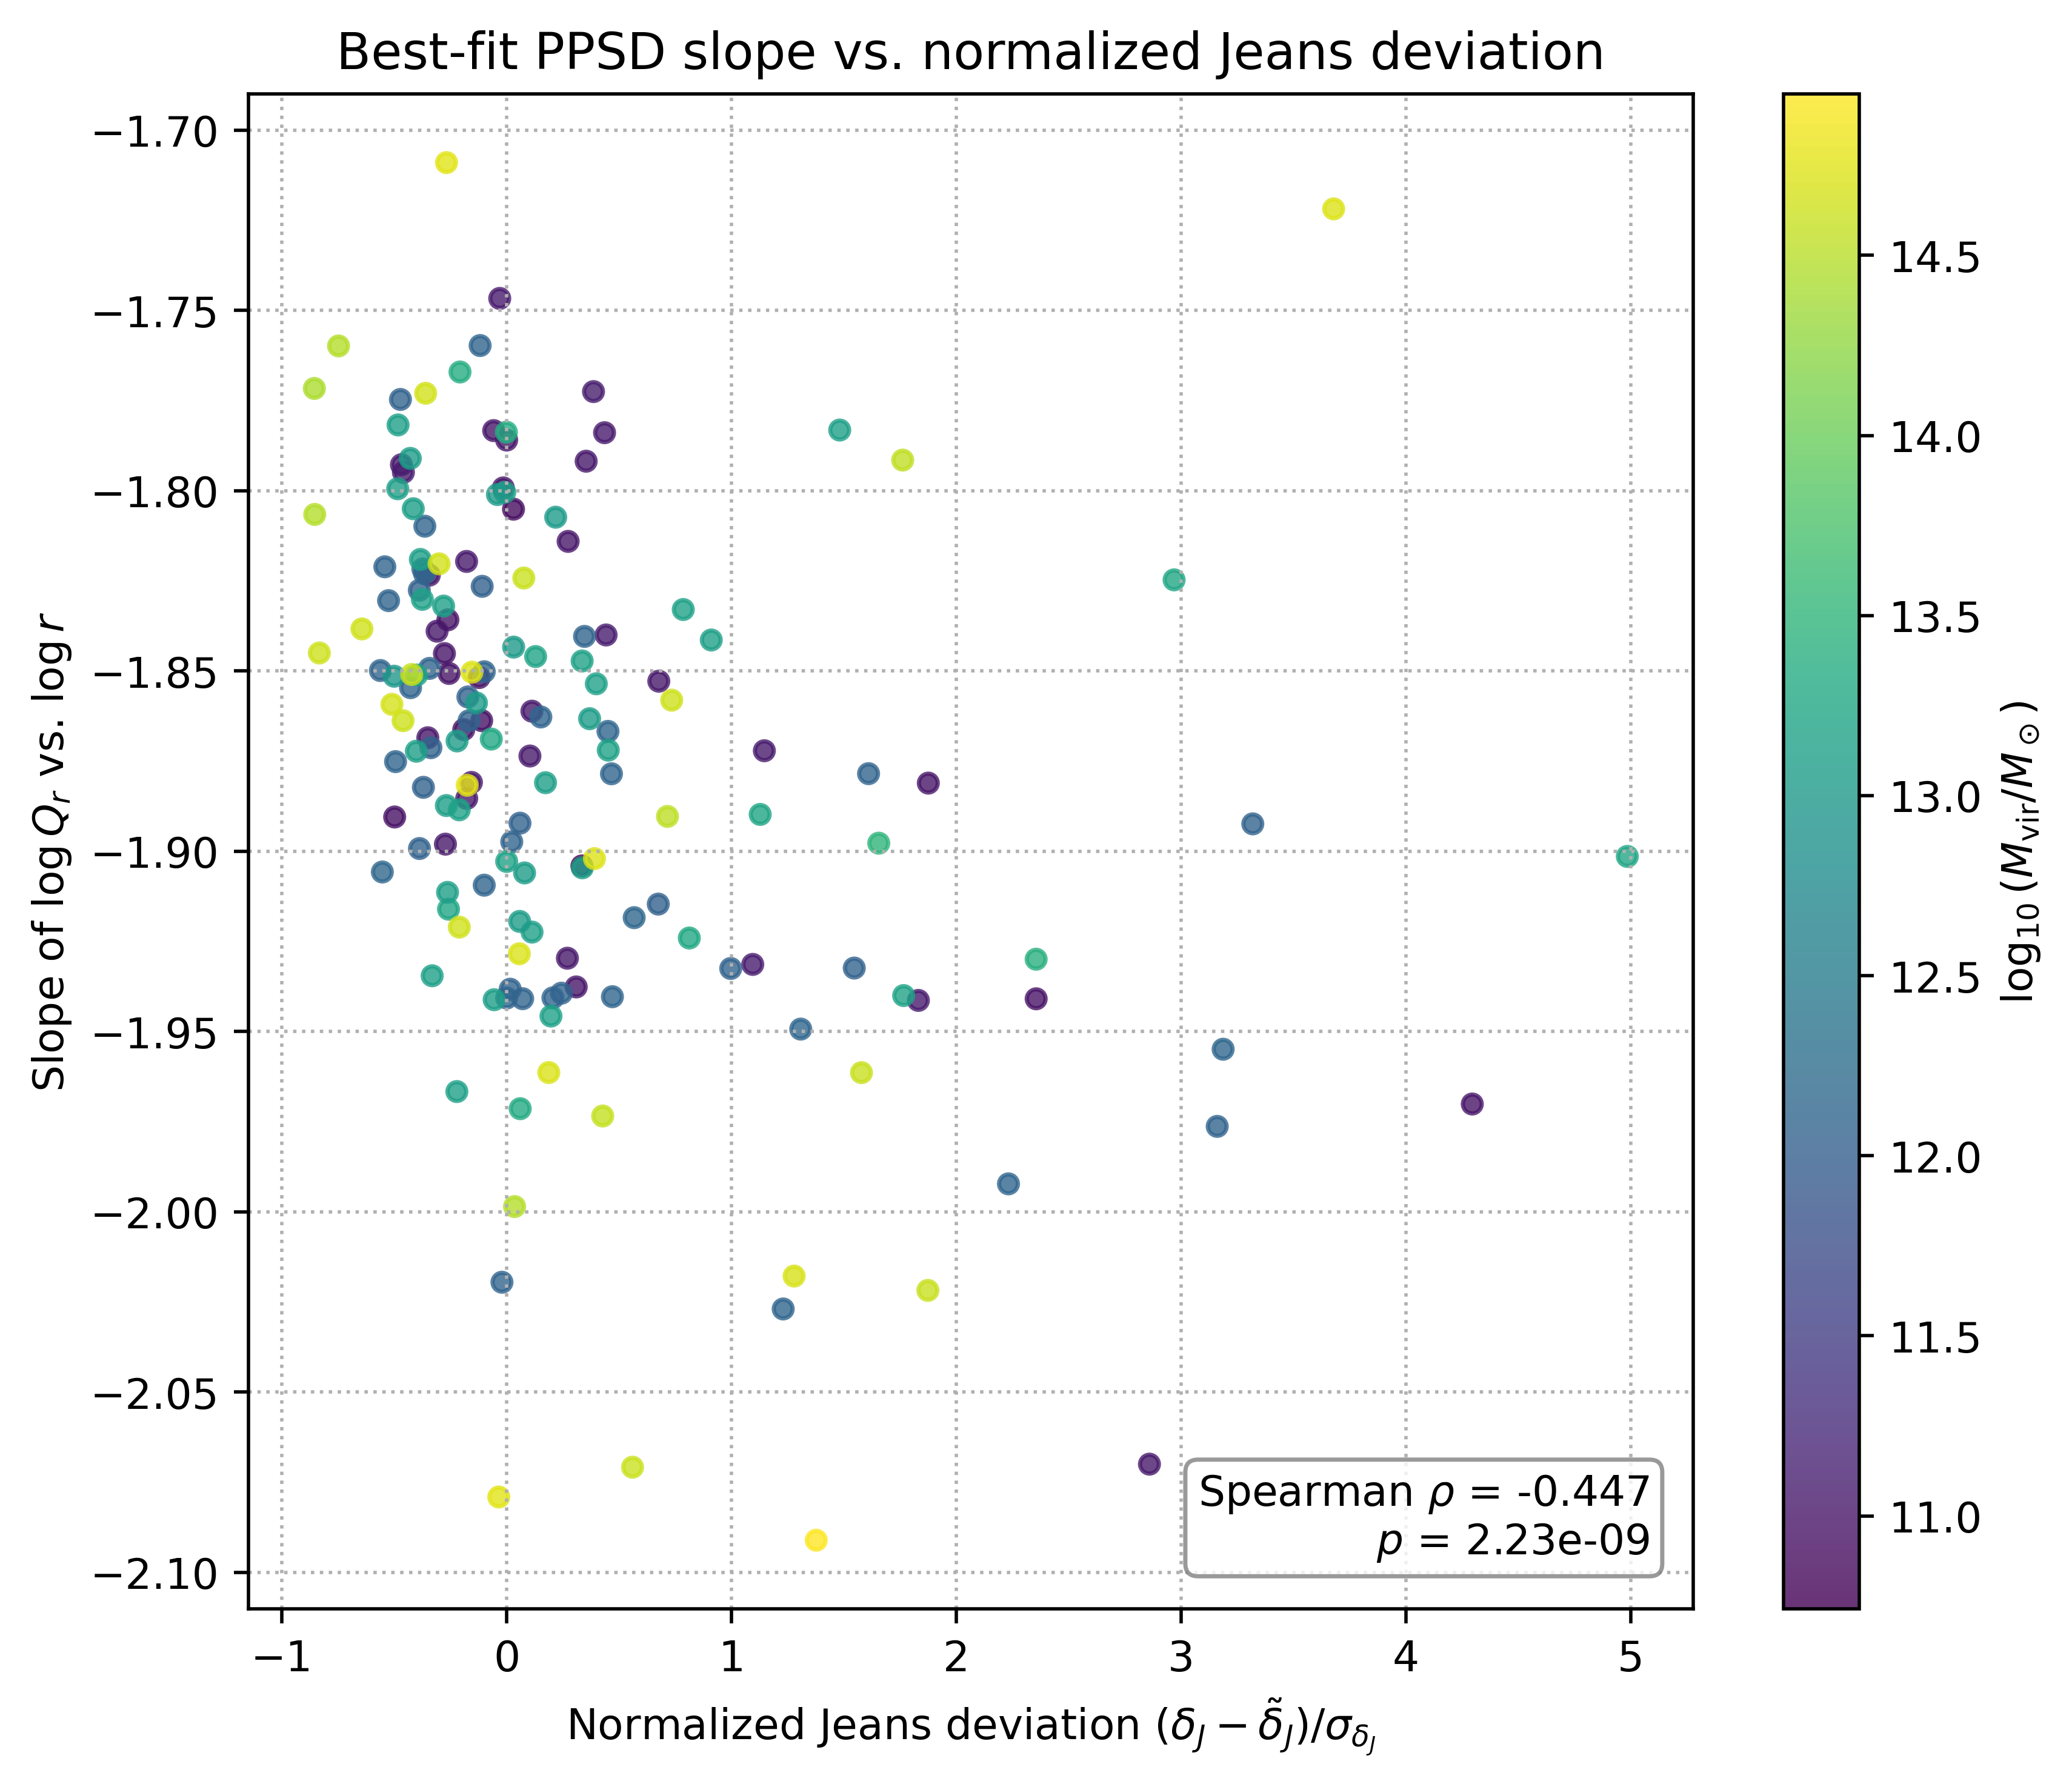

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def fit_loglog_powerlaw(x, y):
    valid = np.isfinite(x) & np.isfinite(y)
    if np.sum(valid) < 5:
        return np.nan
    x, y = x[valid], y[valid]
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    return slope

def plot_bestfit_ppsd_slope_vs_jeans_deviation_norm(
    base_dir,
    suite_names,
    quantity="Q_r",
    r_fit_range=(0.01, 1.0)
):
    slope_vals = []
    jeans_norm_vals = []
    log_mass_vals = []

    for suite in suite_names:
        profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        jeans_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path  = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        # Load Jeans deviation and compute normalization per suite
        df_jeans = pd.read_csv(jeans_path)
        dJ = pd.to_numeric(df_jeans["delta_J_tot"], errors='coerce')
        median_j = np.nanmedian(dJ)
        mean_j   = np.nanmean(dJ)
        std_j    = np.nanstd(dJ)
        jeans_norm_dict = {
            hid: ((dj - median_j) / std_j)
            for hid, dj in zip(df_jeans["halo_id"], dJ)
        }

        # Load masses
        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(
            df_mass["halo_id"],
            pd.to_numeric(df_mass["mvir"], errors='coerce')
        ))

        # Loop over PPSD profiles
        for fname in sorted(os.listdir(profile_dir)):
            if not fname.endswith(".csv"):
                continue
            try:
                halo_id = int(fname.split("_")[1])
                df = pd.read_csv(os.path.join(profile_dir, fname))

                # Extract and restrict radial range
                r = df["r_scaled"].to_numpy(dtype=float)
                Q = df[quantity].to_numpy(dtype=float)
                mask = (r >= r_fit_range[0]) & (r <= r_fit_range[1]) & np.isfinite(Q) & (Q > 0)
                if mask.sum() < 5:
                    continue

                log_r = np.log10(r[mask])
                log_Q = np.log10(Q[mask])
                slope = fit_loglog_powerlaw(log_r, log_Q)

                # Retrieve normalized Jeans deviation and mass
                dj_norm = jeans_norm_dict.get(halo_id, np.nan)
                mvir = mass_dict.get(halo_id, np.nan)

                if np.isfinite(slope) and np.isfinite(dj_norm):
                    slope_vals.append(slope)
                    jeans_norm_vals.append(dj_norm)
                    log_mass_vals.append(np.log10(mvir) if np.isfinite(mvir) else np.nan)

            except Exception as e:
                print(f"[Warning] Failed on {fname} in {suite}: {e}")

    slope_vals = np.array(slope_vals)
    jeans_norm_vals = np.array(jeans_norm_vals)
    log_mass_vals = np.array(log_mass_vals)

    if len(slope_vals) < 5:
        print("[Warning] Not enough data to compute correlation.")
        return

    # Spearman correlation
    rho, pval = spearmanr(jeans_norm_vals, slope_vals)

    # Plot
    plt.figure(figsize=(7, 6), dpi=500)
    sc = plt.scatter(
        jeans_norm_vals,
        slope_vals,
        c=log_mass_vals,
        cmap="viridis",
        s=20,
        alpha=0.8
    )
    cbar = plt.colorbar(sc, label=r"$\log_{10}(M_{\rm vir}/M_\odot)$")
    plt.xlabel(r"Normalized Jeans deviation $(\delta_J - \tilde{\delta}_J)/\sigma_{\delta_J}$")
    plt.ylabel(fr"Slope of $\log {quantity}$ vs. $\log r$")
    plt.title("Best-fit PPSD slope vs. normalized Jeans deviation")
    plt.grid(True, linestyle=":")
    textstr = '\n'.join([
        rf"Spearman $\rho$ = {rho:.3f}",
        rf"$p$ = {pval:.2e}"
    ])
    plt.text(
        0.97, 0.03, textstr,
        transform=plt.gca().transAxes,
        fontsize=10, va="bottom", ha="right",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
    )
    plt.tight_layout()
    plt.show()

# Example usage
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
]
plot_bestfit_ppsd_slope_vs_jeans_deviation_norm(
    base_dir, suite_names,
    quantity="Q_r",
    r_fit_range=(0.001, 1.5)
)


Pairwise K-S test results for normalized Jeans deviation:



Suite 1           Suite 2  KS_jeans_norm_stat  p_jeans_norm
0       SymphonyLMC  SymphonyMilkyWay            0.211966      0.258638
1       SymphonyLMC     SymphonyGroup            0.110937      0.914200
2       SymphonyLMC  SymphonyLCluster            0.223077      0.312192
3       SymphonyLMC   SymphonyCluster            0.416667      0.000180
4  SymphonyMilkyWay     SymphonyGroup            0.149660      0.597375
5  SymphonyMilkyWay  SymphonyLCluster            0.166667      0.659964
6  SymphonyMilkyWay   SymphonyCluster            0.402778      0.000156
7     SymphonyGroup  SymphonyLCluster            0.200000      0.380654
8     SymphonyGroup   SymphonyCluster            0.416667      0.000044
9  SymphonyLCluster   SymphonyCluster            0.347222      0.008924

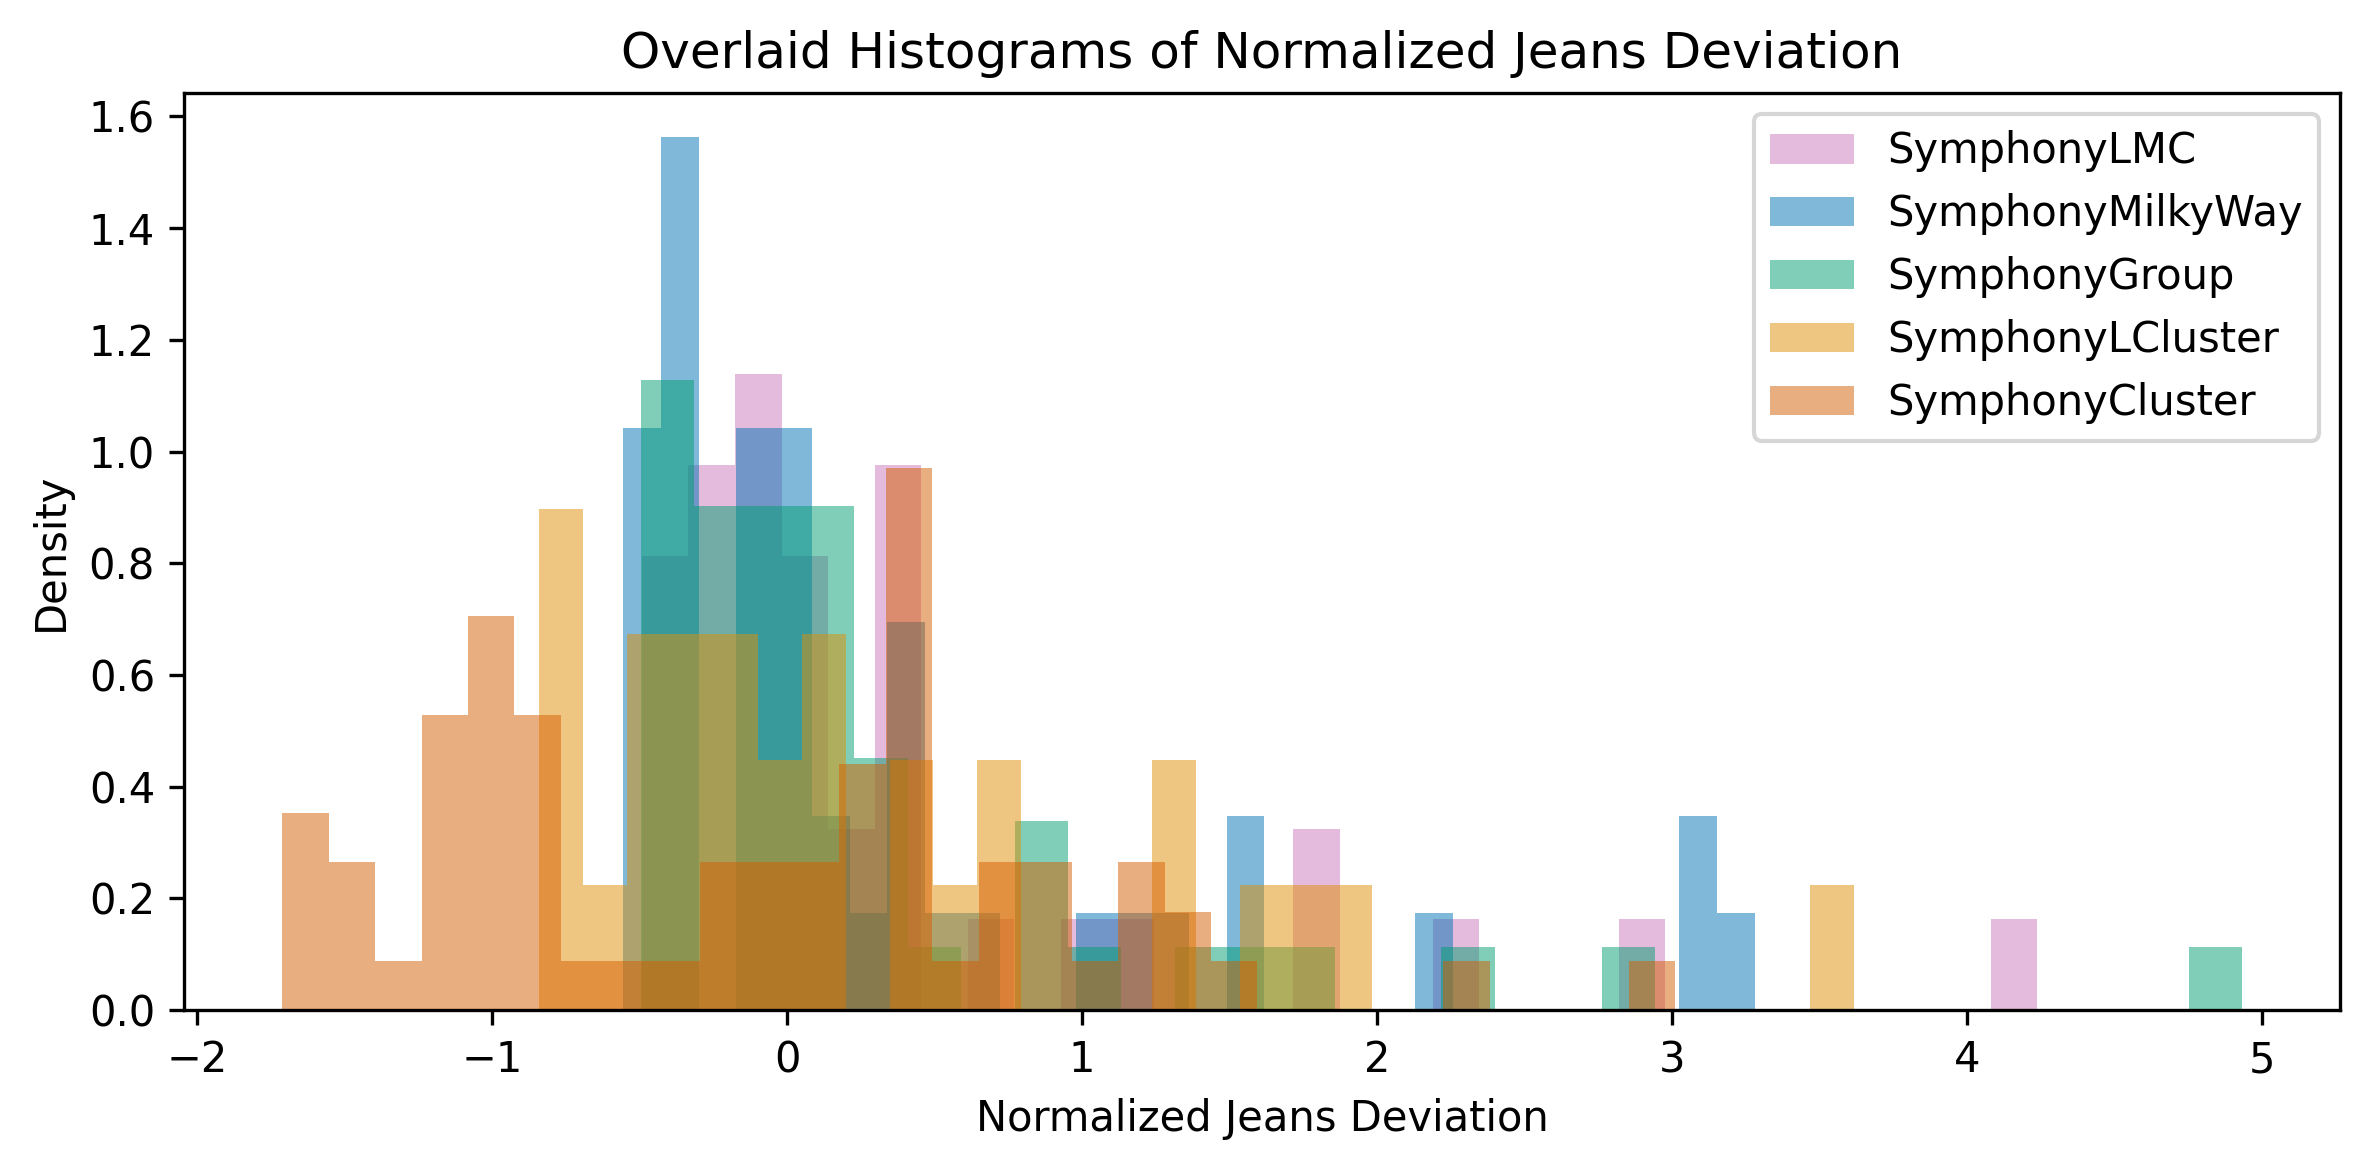

/var/folders/ws/425czmvd4jn8yf9hxr3xtk880000gn/T/ipykernel_28848/2225465937.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([delta_jeans[s] for s in suite_names],


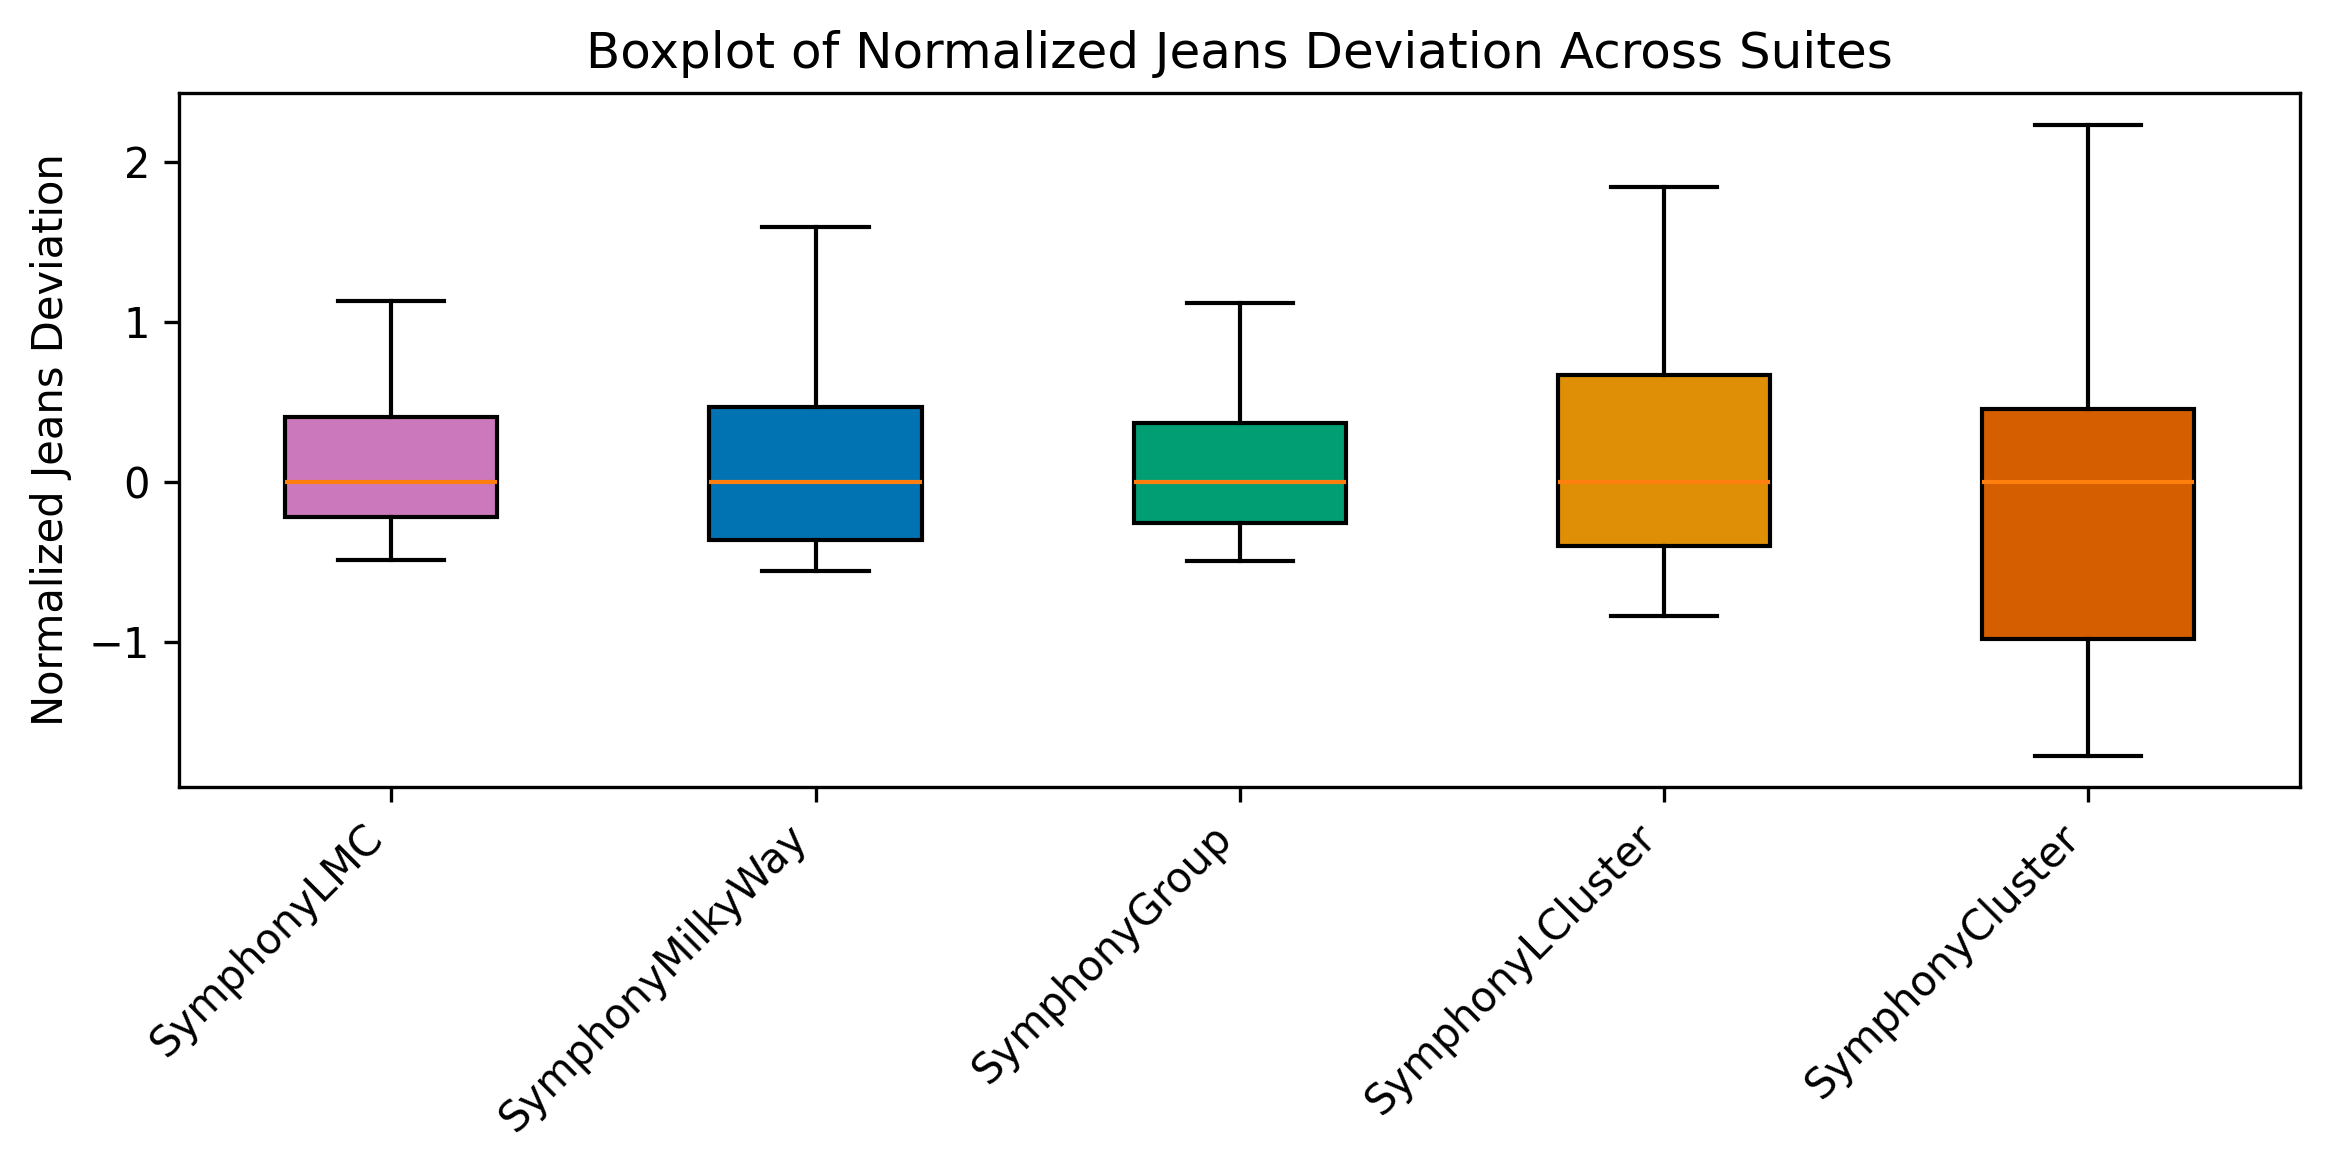

In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# === User-configurable parameters ===
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster"
]

# === Color palette ===
sim_colors = {
    'SymphonyLMC':        sns.color_palette("colorblind")[4],
    'SymphonyMilkyWay':   sns.color_palette("colorblind")[0],
    'SymphonyGroup':      sns.color_palette("colorblind")[2],
    'SymphonyLCluster':   sns.color_palette("colorblind")[1],
    'SymphonyCluster':    sns.color_palette("colorblind")[3]
}

# === Load and normalize Jeans deviation ===
def load_delta_jeans_norm(suite):
    path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
    df = pd.read_csv(path)
    dJ = pd.to_numeric(df["delta_J_tot"], errors='coerce').dropna()
    return ((dJ - dJ.median()) / dJ.std()).values

delta_jeans = {s: load_delta_jeans_norm(s) for s in suite_names}

# === Pairwise K-S tests ===
def ks_test_across_suites(delta_dict, metric_name):
    results = []
    for s1, s2 in itertools.combinations(suite_names, 2):
        data1 = delta_dict[s1]
        data2 = delta_dict[s2]
        ks_stat, p_value = ks_2samp(data1, data2)
        results.append({
            "Suite 1": s1,
            "Suite 2": s2,
            f"KS_{metric_name}_stat": ks_stat,
            f"p_{metric_name}": p_value
        })
    return pd.DataFrame(results)

ks_j_df = ks_test_across_suites(delta_jeans, "jeans_norm")

# === Display K-S test results ===
print("Pairwise K-S test results for normalized Jeans deviation:\n")
display(ks_j_df)

# === Visualization ===
plt.figure(figsize=(8, 4), dpi=400)
for suite, data in delta_jeans.items():
    plt.hist(data, bins=30, density=True, alpha=0.5,
             color=sim_colors[suite], label=suite)
plt.xlabel("Normalized Jeans Deviation")
plt.ylabel("Density")
plt.title("Overlaid Histograms of Normalized Jeans Deviation")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4), dpi=400)
bp = plt.boxplot([delta_jeans[s] for s in suite_names],
                 labels=suite_names, patch_artist=True, showfliers=False)
for patch, suite in zip(bp['boxes'], suite_names):
    patch.set_facecolor(sim_colors[suite])
plt.ylabel("Normalized Jeans Deviation")
plt.title("Boxplot of Normalized Jeans Deviation Across Suites")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


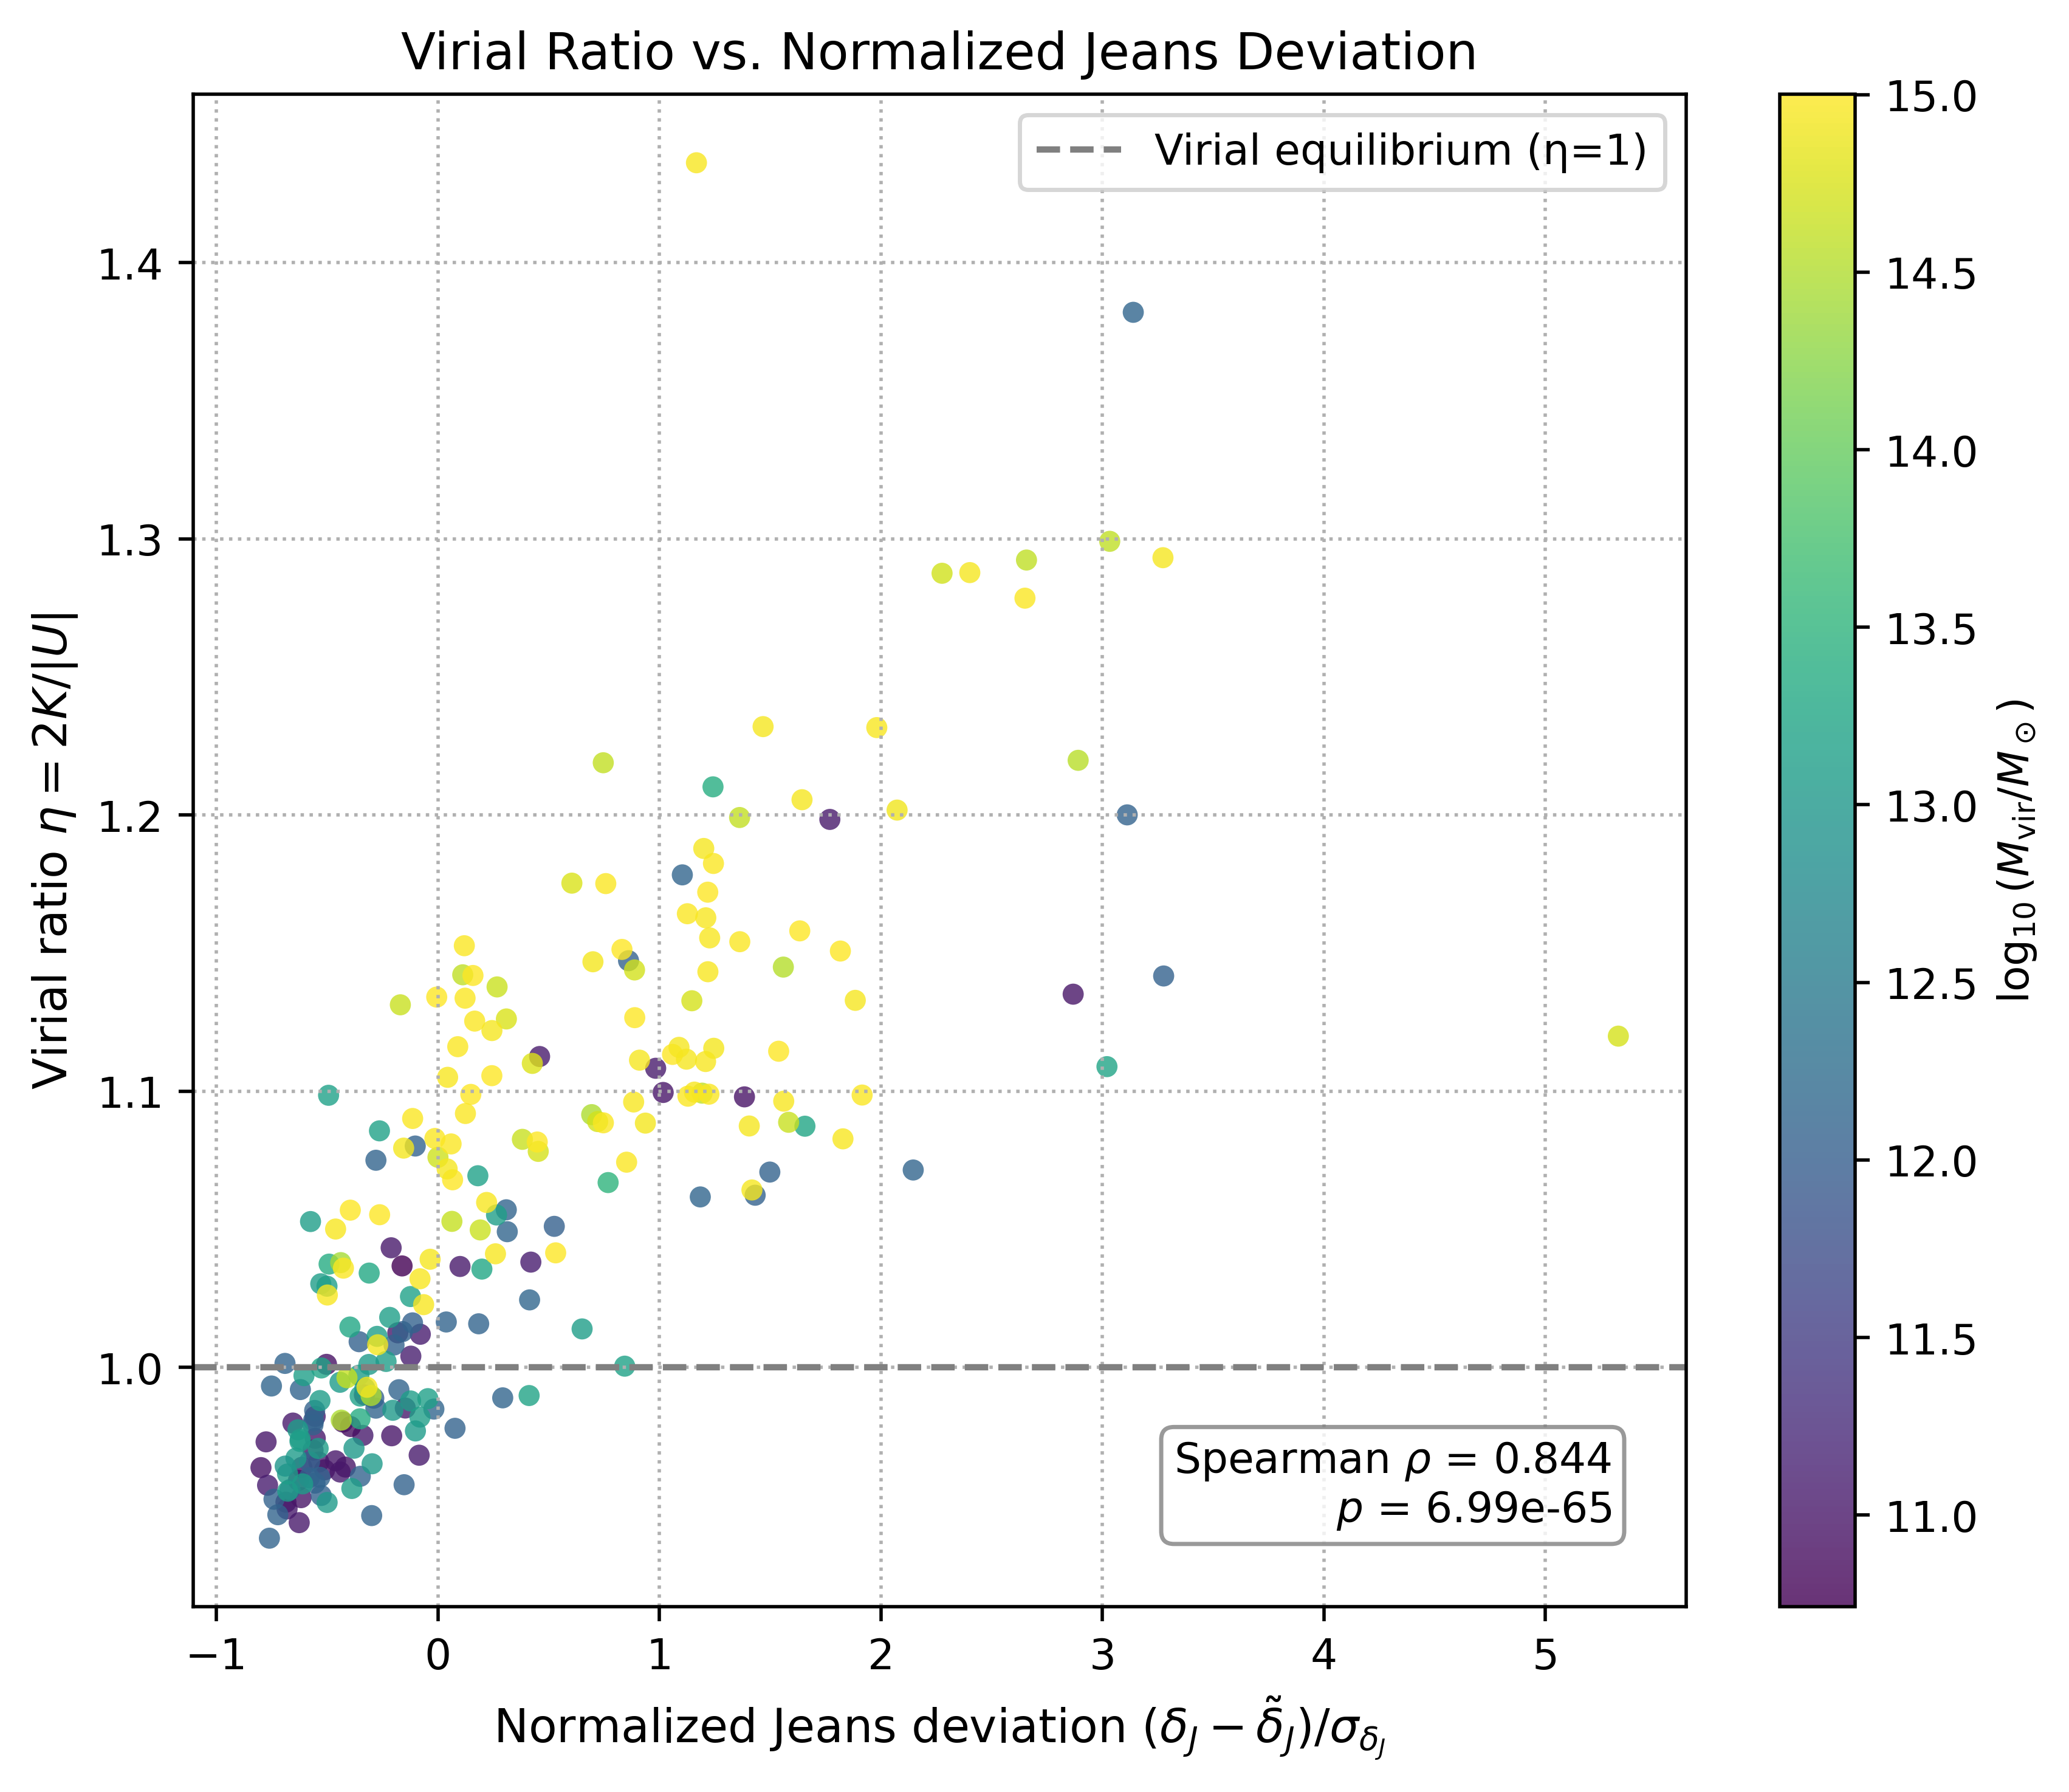

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

G = 1 

def compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_r, sigma_tan):
    dr = np.gradient(r)
    vol = 4 * np.pi * r**2

    sigma2_tot = sigma_r**2 + sigma_tan**2

    # Scaled kinetic energy
    integrand_K = 0.5 * rho * sigma2_tot * vol
    K = np.sum(integrand_K * dr)

    # Scaled potential energy
    integrand_U = -m_enc * rho / r * vol
    U = np.sum(integrand_U * dr)

    if U >= 0 or K <= 0:
        return np.nan
    return 2 * K / abs(U)

def compare_normalized_jeans_deviation_vs_virial_ratio(base_dir, suite_names):
    """
    Compute and plot the relation between z-score–normalized total Jeans deviation
    and the virial ratio η = 2K/|U|, coloring points by log10(M_vir).
    Normalization of δJ is (δJ - median(δJ)) / std(δJ).
    """
    delta_J_list = []
    eta_list     = []
    mass_list    = []

    # 1) Gather raw δJ, η, and M_vir for all halos
    for suite in suite_names:
        density_dir = os.path.join(base_dir, "output", suite, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        mass_dir    = os.path.join(base_dir, "output", suite, "mass_profiles")
        jeans_path  = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path   = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        # load δJ_tot per halo
        df_jeans = pd.read_csv(jeans_path)
        jeans_dict = dict(zip(df_jeans["halo_id"],
                              pd.to_numeric(df_jeans["delta_J_tot"], errors='coerce')))
        # load M_vir per halo
        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(df_mass["halo_id"],
                             pd.to_numeric(df_mass["mvir"], errors='coerce')))

        # loop through each halo’s density file to compute η
        for fname in sorted(os.listdir(density_dir)):
            if not fname.endswith(".csv"):
                continue
            try:
                halo_id = int(fname.split("_")[1])
                if halo_id not in jeans_dict or halo_id not in mass_dict:
                    continue

                # read profiles
                df_rho = pd.read_csv(os.path.join(density_dir, fname))
                df_vel = pd.read_csv(os.path.join(velocity_dir, fname))
                df_menc= pd.read_csv(os.path.join(mass_dir, fname))

                r      = pd.to_numeric(df_rho["r_scaled"], errors='coerce').values
                rho    = pd.to_numeric(df_rho["rho_scaled"], errors='coerce').values
                m_enc  = pd.to_numeric(df_menc["m_scaled"], errors='coerce').values
                sigma_r   = pd.to_numeric(df_vel["sigma_rad_scaled"], errors='coerce').values
                sigma_tan = pd.to_numeric(df_vel["sigma_tan_scaled"], errors='coerce').values

                # require matching lengths
                if not (len(r)==len(rho)==len(m_enc)==len(sigma_r)==len(sigma_tan)):
                    continue

                # compute virial ratio η = 2K/|U|
                eta = compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_r, sigma_tan)
                delta_J = jeans_dict[halo_id]
                mvir    = mass_dict[halo_id]

                if np.isfinite(eta) and np.isfinite(delta_J) and np.isfinite(mvir):
                    eta_list.append(eta)
                    delta_J_list.append(delta_J)
                    mass_list.append(mvir)

            except Exception as e:
                print(f"[Warning] failed to process {suite} halo {fname}: {e}")

    # convert to arrays
    delta_J_arr = np.array(delta_J_list)
    eta_arr     = np.array(eta_list)
    logM_arr    = np.log10(np.array(mass_list))

    # check we have enough halos
    if delta_J_arr.size < 5:
        print("[Warning] Too few halos for meaningful correlation.")
        return

    # 2) normalize δJ by median and std
    med_J = np.median(delta_J_arr)
    std_J = np.std(delta_J_arr)
    if std_J <= 0:
        print("[Warning] zero variance in Jeans deviation; cannot normalize.")
        return
    delta_J_norm = (delta_J_arr - med_J) / std_J

    # 3) compute Spearman correlation
    rho_s, p_s = spearmanr(delta_J_norm, eta_arr)

    # 4) plotting
    plt.figure(figsize=(7,6), dpi=500)
    sc = plt.scatter(
        delta_J_norm, eta_arr,
        c=logM_arr, cmap="viridis", s=25, alpha=0.8, edgecolors="none"
    )
    plt.axhline(1.0, color="gray", linestyle="--", label="Virial equilibrium (η=1)")
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=10)

    plt.xlabel(r"Normalized Jeans deviation $(\delta_J - \tilde{\delta}_J)/\sigma_{\delta_J}$", fontsize=11)
    plt.ylabel(r"Virial ratio $\eta = 2K/|U|$", fontsize=11)
    plt.title("Virial Ratio vs. Normalized Jeans Deviation", fontsize=12)
    plt.grid(True, linestyle=":")
    plt.legend(loc="upper right", fontsize=10)

    txt = f"Spearman $\\rho$ = {rho_s:.3f}\n$p$ = {p_s:.2e}"
    plt.text(0.95, 0.05, txt,
             transform=plt.gca().transAxes,
             ha='right', va='bottom',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             fontsize=10)

    plt.tight_layout()
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = [
    "SymphonyLMC",
    "SymphonyMilkyWay",
    "SymphonyGroup",
    "SymphonyLCluster",
    "SymphonyCluster"
]

compare_normalized_jeans_deviation_vs_virial_ratio(base_dir, suite_names)


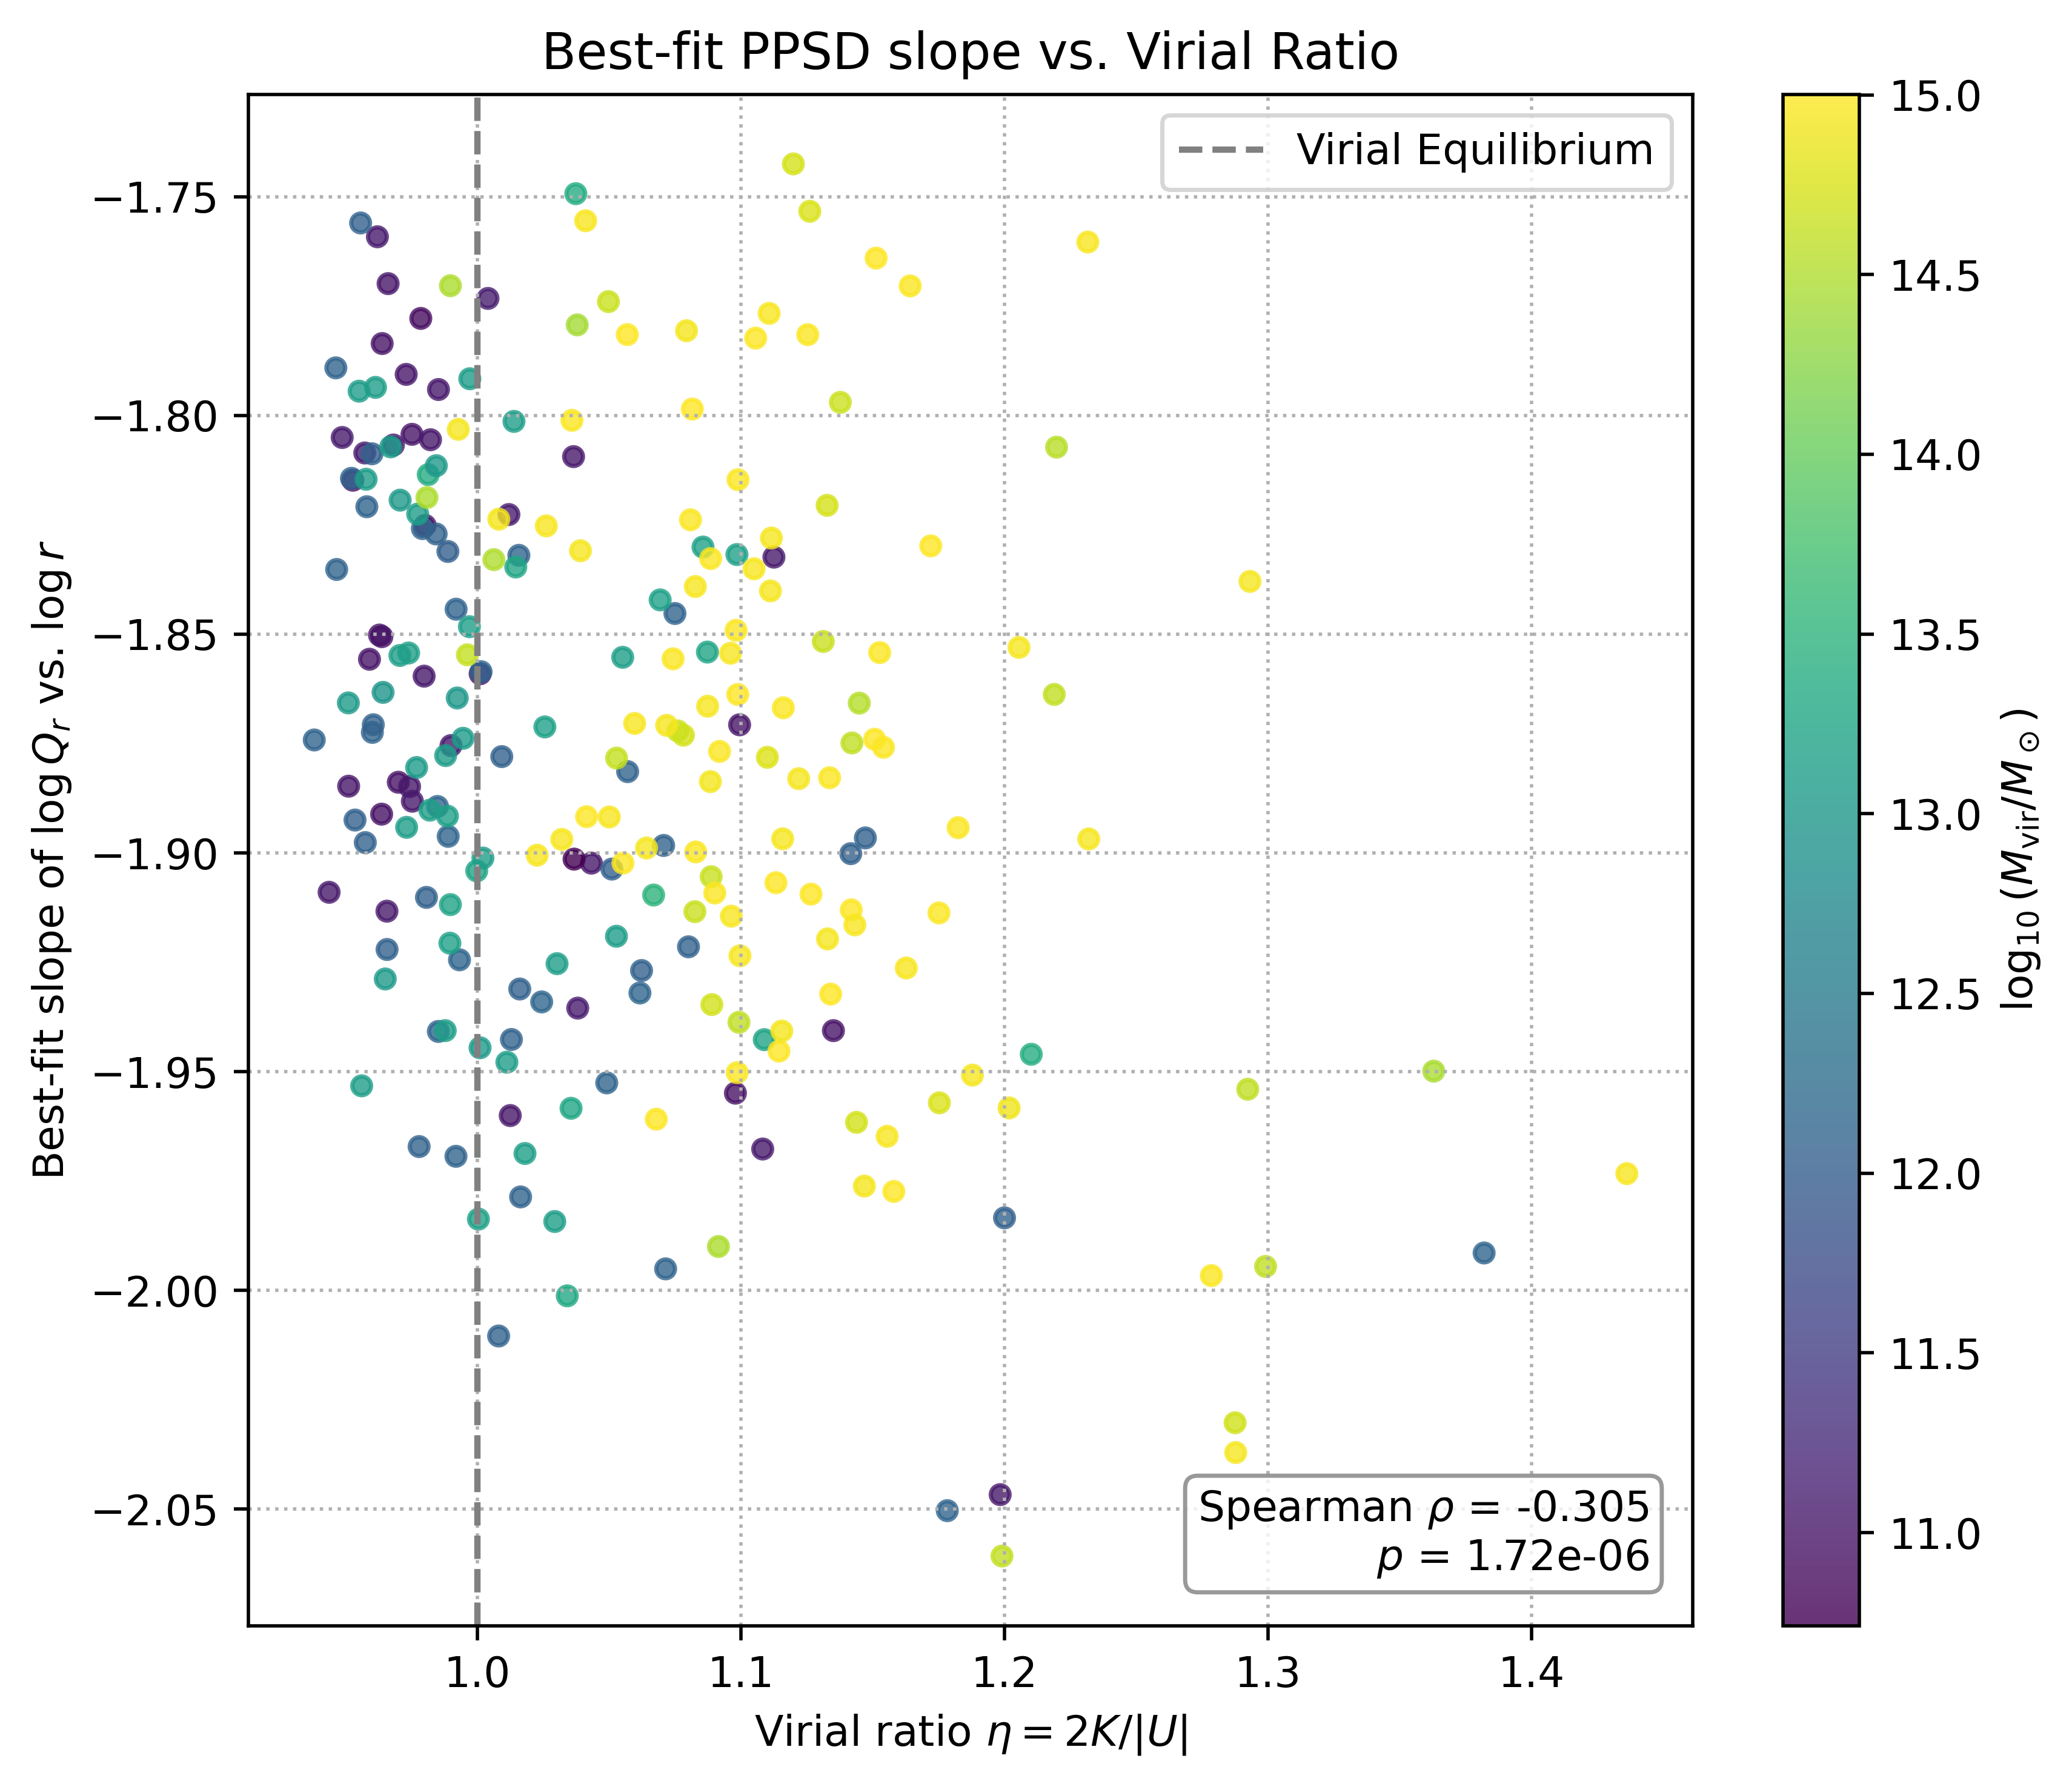

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

def fit_loglog_powerlaw(x, y):
    valid = np.isfinite(x) & np.isfinite(y)
    if np.sum(valid) < 5:
        return np.nan
    A = np.vstack([x[valid], np.ones_like(x[valid])]).T
    slope, intercept = np.linalg.lstsq(A, y[valid], rcond=None)[0]
    return slope

def compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_r, sigma_tan):
    dr = np.gradient(r)
    vol = 4 * np.pi * r**2
    sigma2_tot = sigma_r**2 + sigma_tan**2

    K = np.sum(0.5 * rho * sigma2_tot * vol * dr)
    U = np.sum(-m_enc * rho / r * vol * dr)
    if U >= 0 or K <= 0:
        return np.nan
    return 2 * K / abs(U)

def plot_bestfit_ppsd_slope_vs_virial_ratio(base_dir, suite_names, quantity="Q_r", r_fit_range=(0.01, 1.0)):
    slope_vals, eta_vals, log_mass_vals = [], [], []

    for suite in suite_names:
        profile_dir = os.path.join(base_dir, "output", suite, "ppsd_profiles")
        density_dir = os.path.join(base_dir, "output", suite, "density_profiles")
        velocity_dir = os.path.join(base_dir, "output", suite, "velocity_profiles")
        mass_dir = os.path.join(base_dir, "output", suite, "mass_profiles")
        mass_info_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_mass = pd.read_csv(mass_info_path)
        mass_dict = dict(zip(df_mass["halo_id"], df_mass["mvir"]))

        for f in sorted(os.listdir(profile_dir)):
            if not f.endswith(".csv"):
                continue
            try:
                halo_id = int(f.split("_")[1])
                df_profile = pd.read_csv(os.path.join(profile_dir, f))
                df_rho = pd.read_csv(os.path.join(density_dir, f))
                df_vel = pd.read_csv(os.path.join(velocity_dir, f))
                df_mass_profile = pd.read_csv(os.path.join(mass_dir, f))

                r = df_rho["r_scaled"].values
                rho = df_rho["rho_scaled"].values
                m_enc = df_mass_profile["m_scaled"].values
                sigma_r = df_vel["sigma_rad_scaled"].values
                sigma_tan = df_vel["sigma_tan_scaled"].values

                Q = df_profile[quantity].values
                r_ppsd = df_profile["r_scaled"].values

                valid = (r_ppsd >= r_fit_range[0]) & (r_ppsd <= r_fit_range[1]) & np.isfinite(Q) & (Q > 0)
                if np.sum(valid) < 5:
                    continue

                log_r = np.log10(r_ppsd[valid])
                log_Q = np.log10(Q[valid])
                slope = fit_loglog_powerlaw(log_r, log_Q)

                eta = compute_eta_from_scaled_profiles(r, rho, m_enc, sigma_r, sigma_tan)
                mass = mass_dict.get(halo_id, np.nan)

                if np.isfinite(slope) and np.isfinite(eta):
                    slope_vals.append(slope)
                    eta_vals.append(eta)
                    log_mass_vals.append(np.log10(mass) if np.isfinite(mass) else np.nan)

            except Exception as e:
                print(f"[Warning] Failed to process halo {f} in {suite}: {e}")

    slope_vals = np.array(slope_vals)
    eta_vals = np.array(eta_vals)
    log_mass_vals = np.array(log_mass_vals)

    if len(slope_vals) < 5:
        print("[Warning] Not enough data to analyze correlation.")
        return

    spearman_r, spearman_p = spearmanr(eta_vals, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    sc = plt.scatter(eta_vals, slope_vals, c=log_mass_vals, cmap="viridis", s=20, alpha=0.8)
    plt.axvline(1.0, color="gray", linestyle="--", label="Virial Equilibrium")
    plt.xlabel(r"Virial ratio $\eta = 2K/|U|$")
    plt.ylabel(rf"Best-fit slope of $\log {quantity}$ vs. $\log r$")
    plt.title("Best-fit PPSD slope vs. Virial Ratio")
    plt.grid(True, linestyle=":")
    plt.colorbar(sc, label=r"$\log_{10}(M_{\rm vir}/M_\odot)$")
    plt.legend()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}",
        rf"$p$ = {spearman_p:.2e}",
    ))
    plt.text(0.97, 0.03, textstr, transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    plt.tight_layout()
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

plot_bestfit_ppsd_slope_vs_virial_ratio(
    base_dir, suite_names,
    quantity="Q_r",         
    r_fit_range=(0.001, 1.0)
)

[Result] Spearman ρ = -0.574, p = 5.29e-22


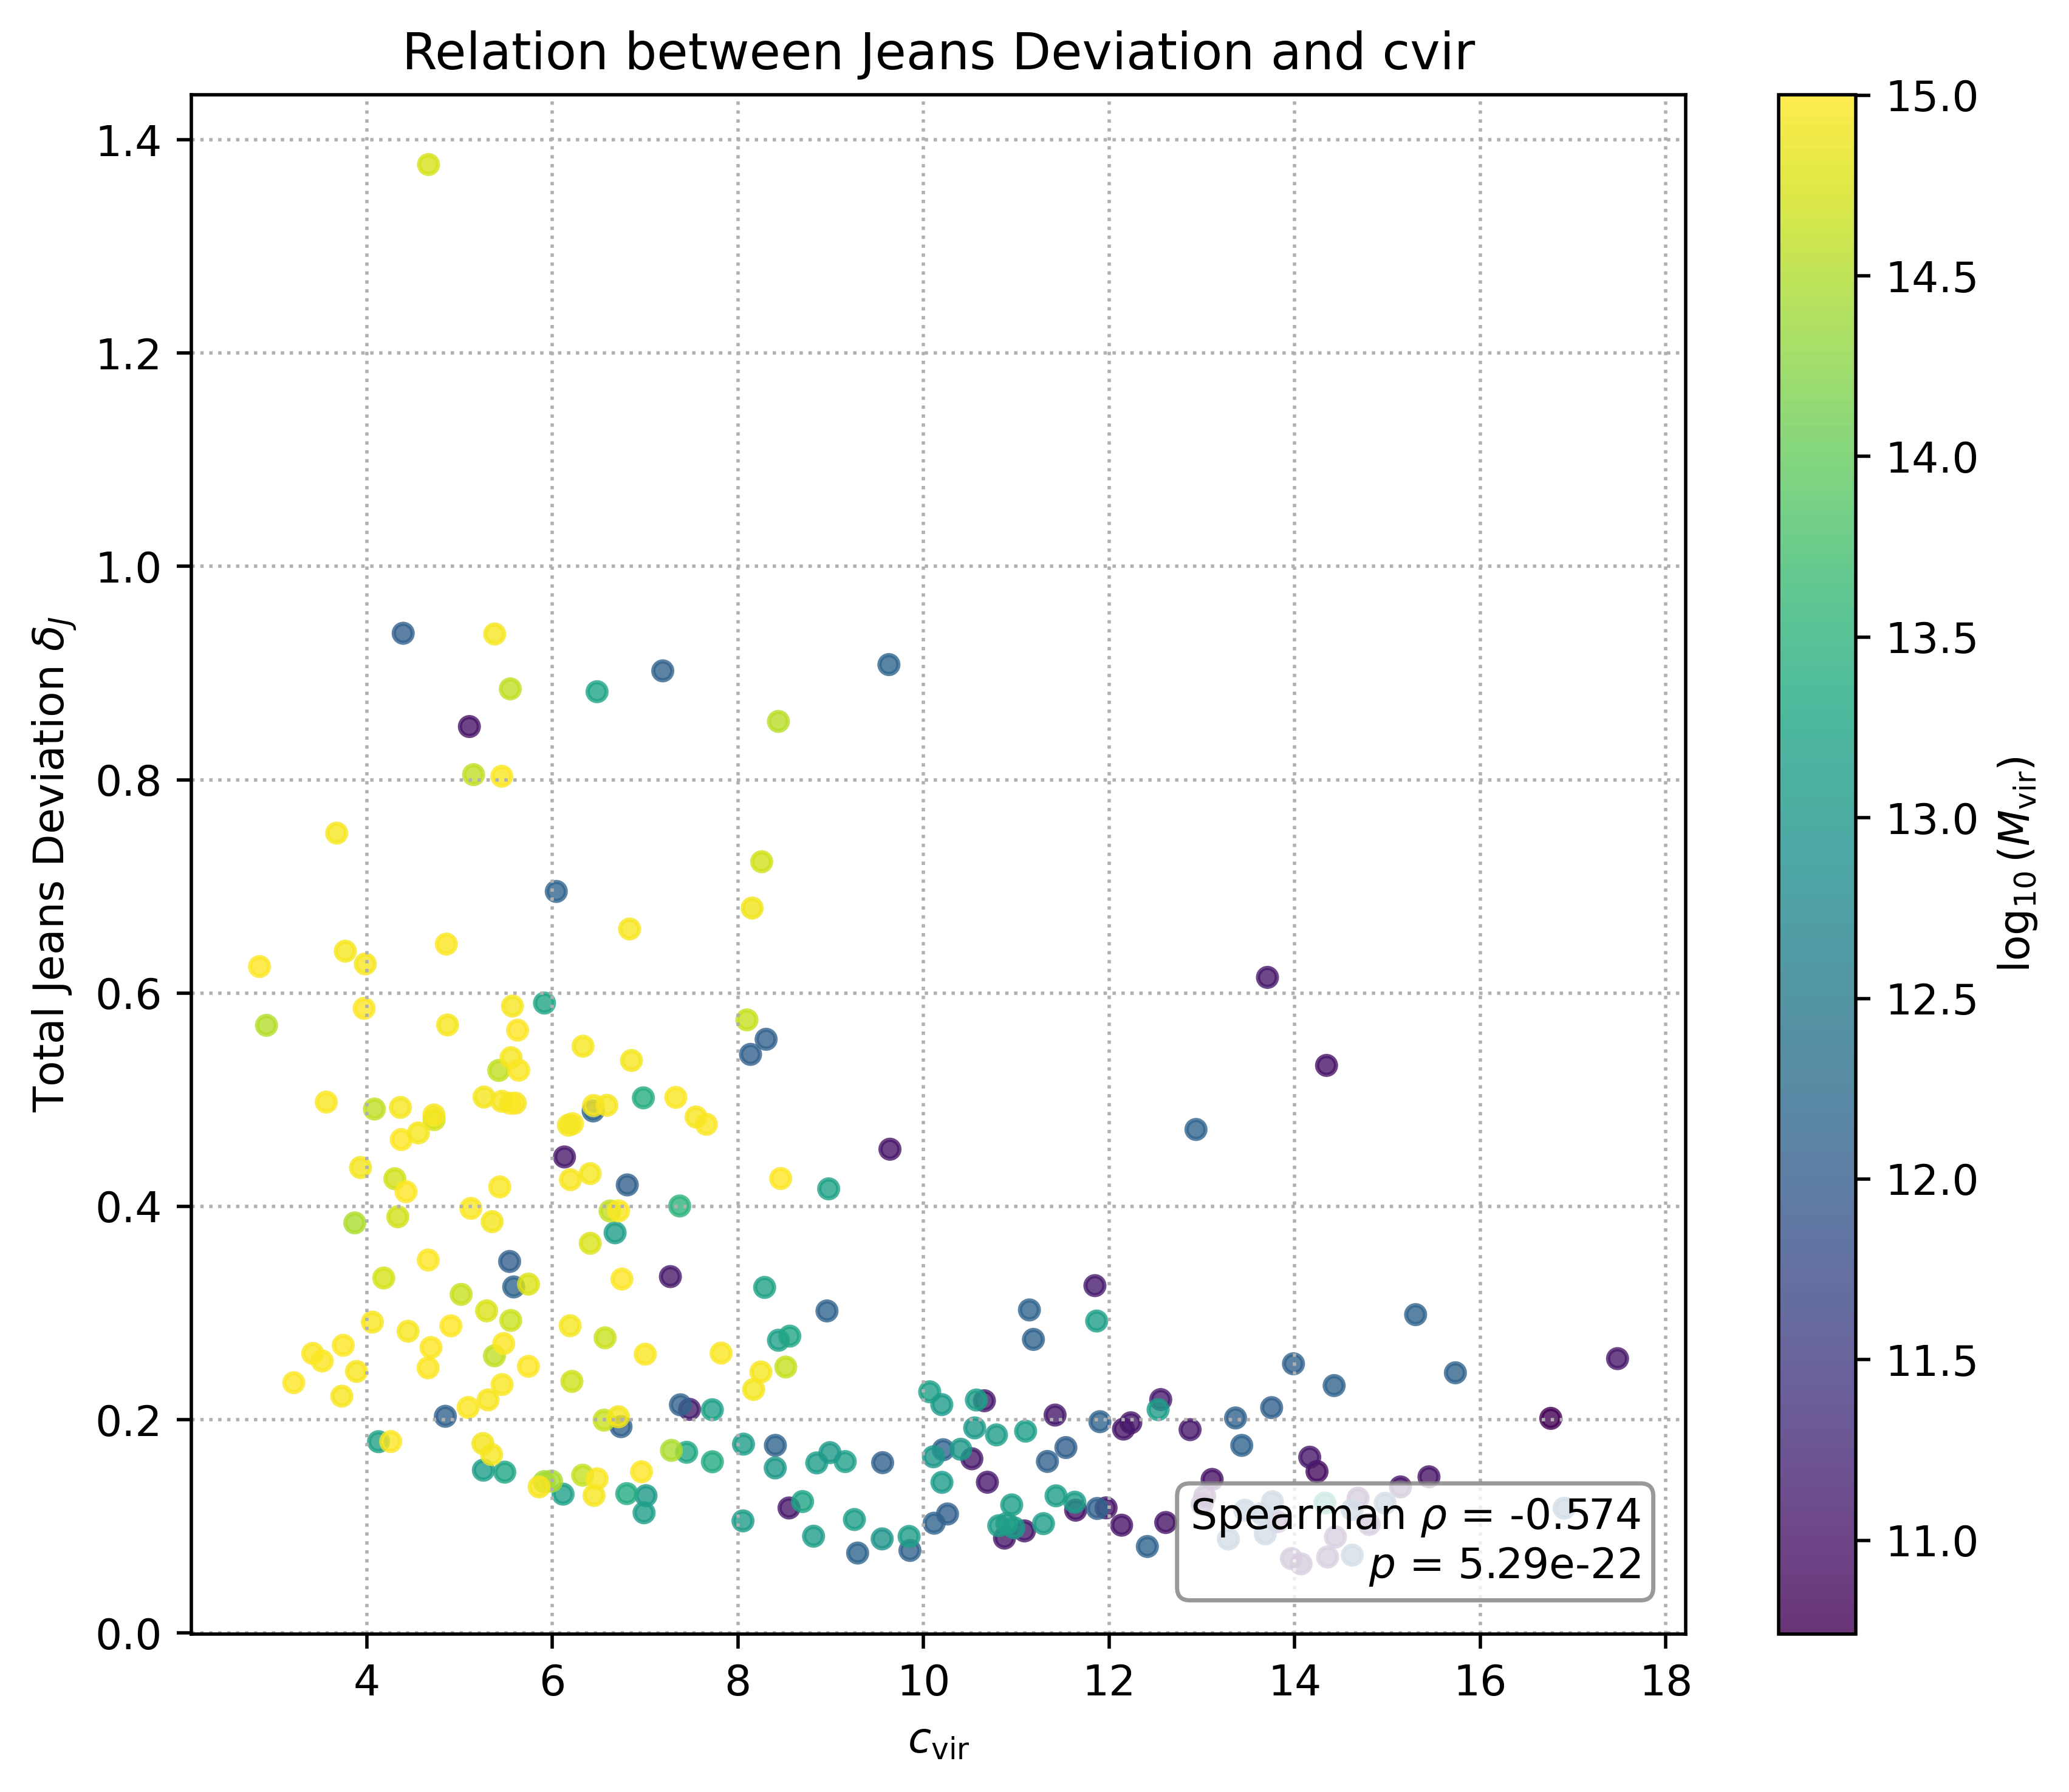

[Result] Spearman ρ = 0.611, p = 1.87e-23


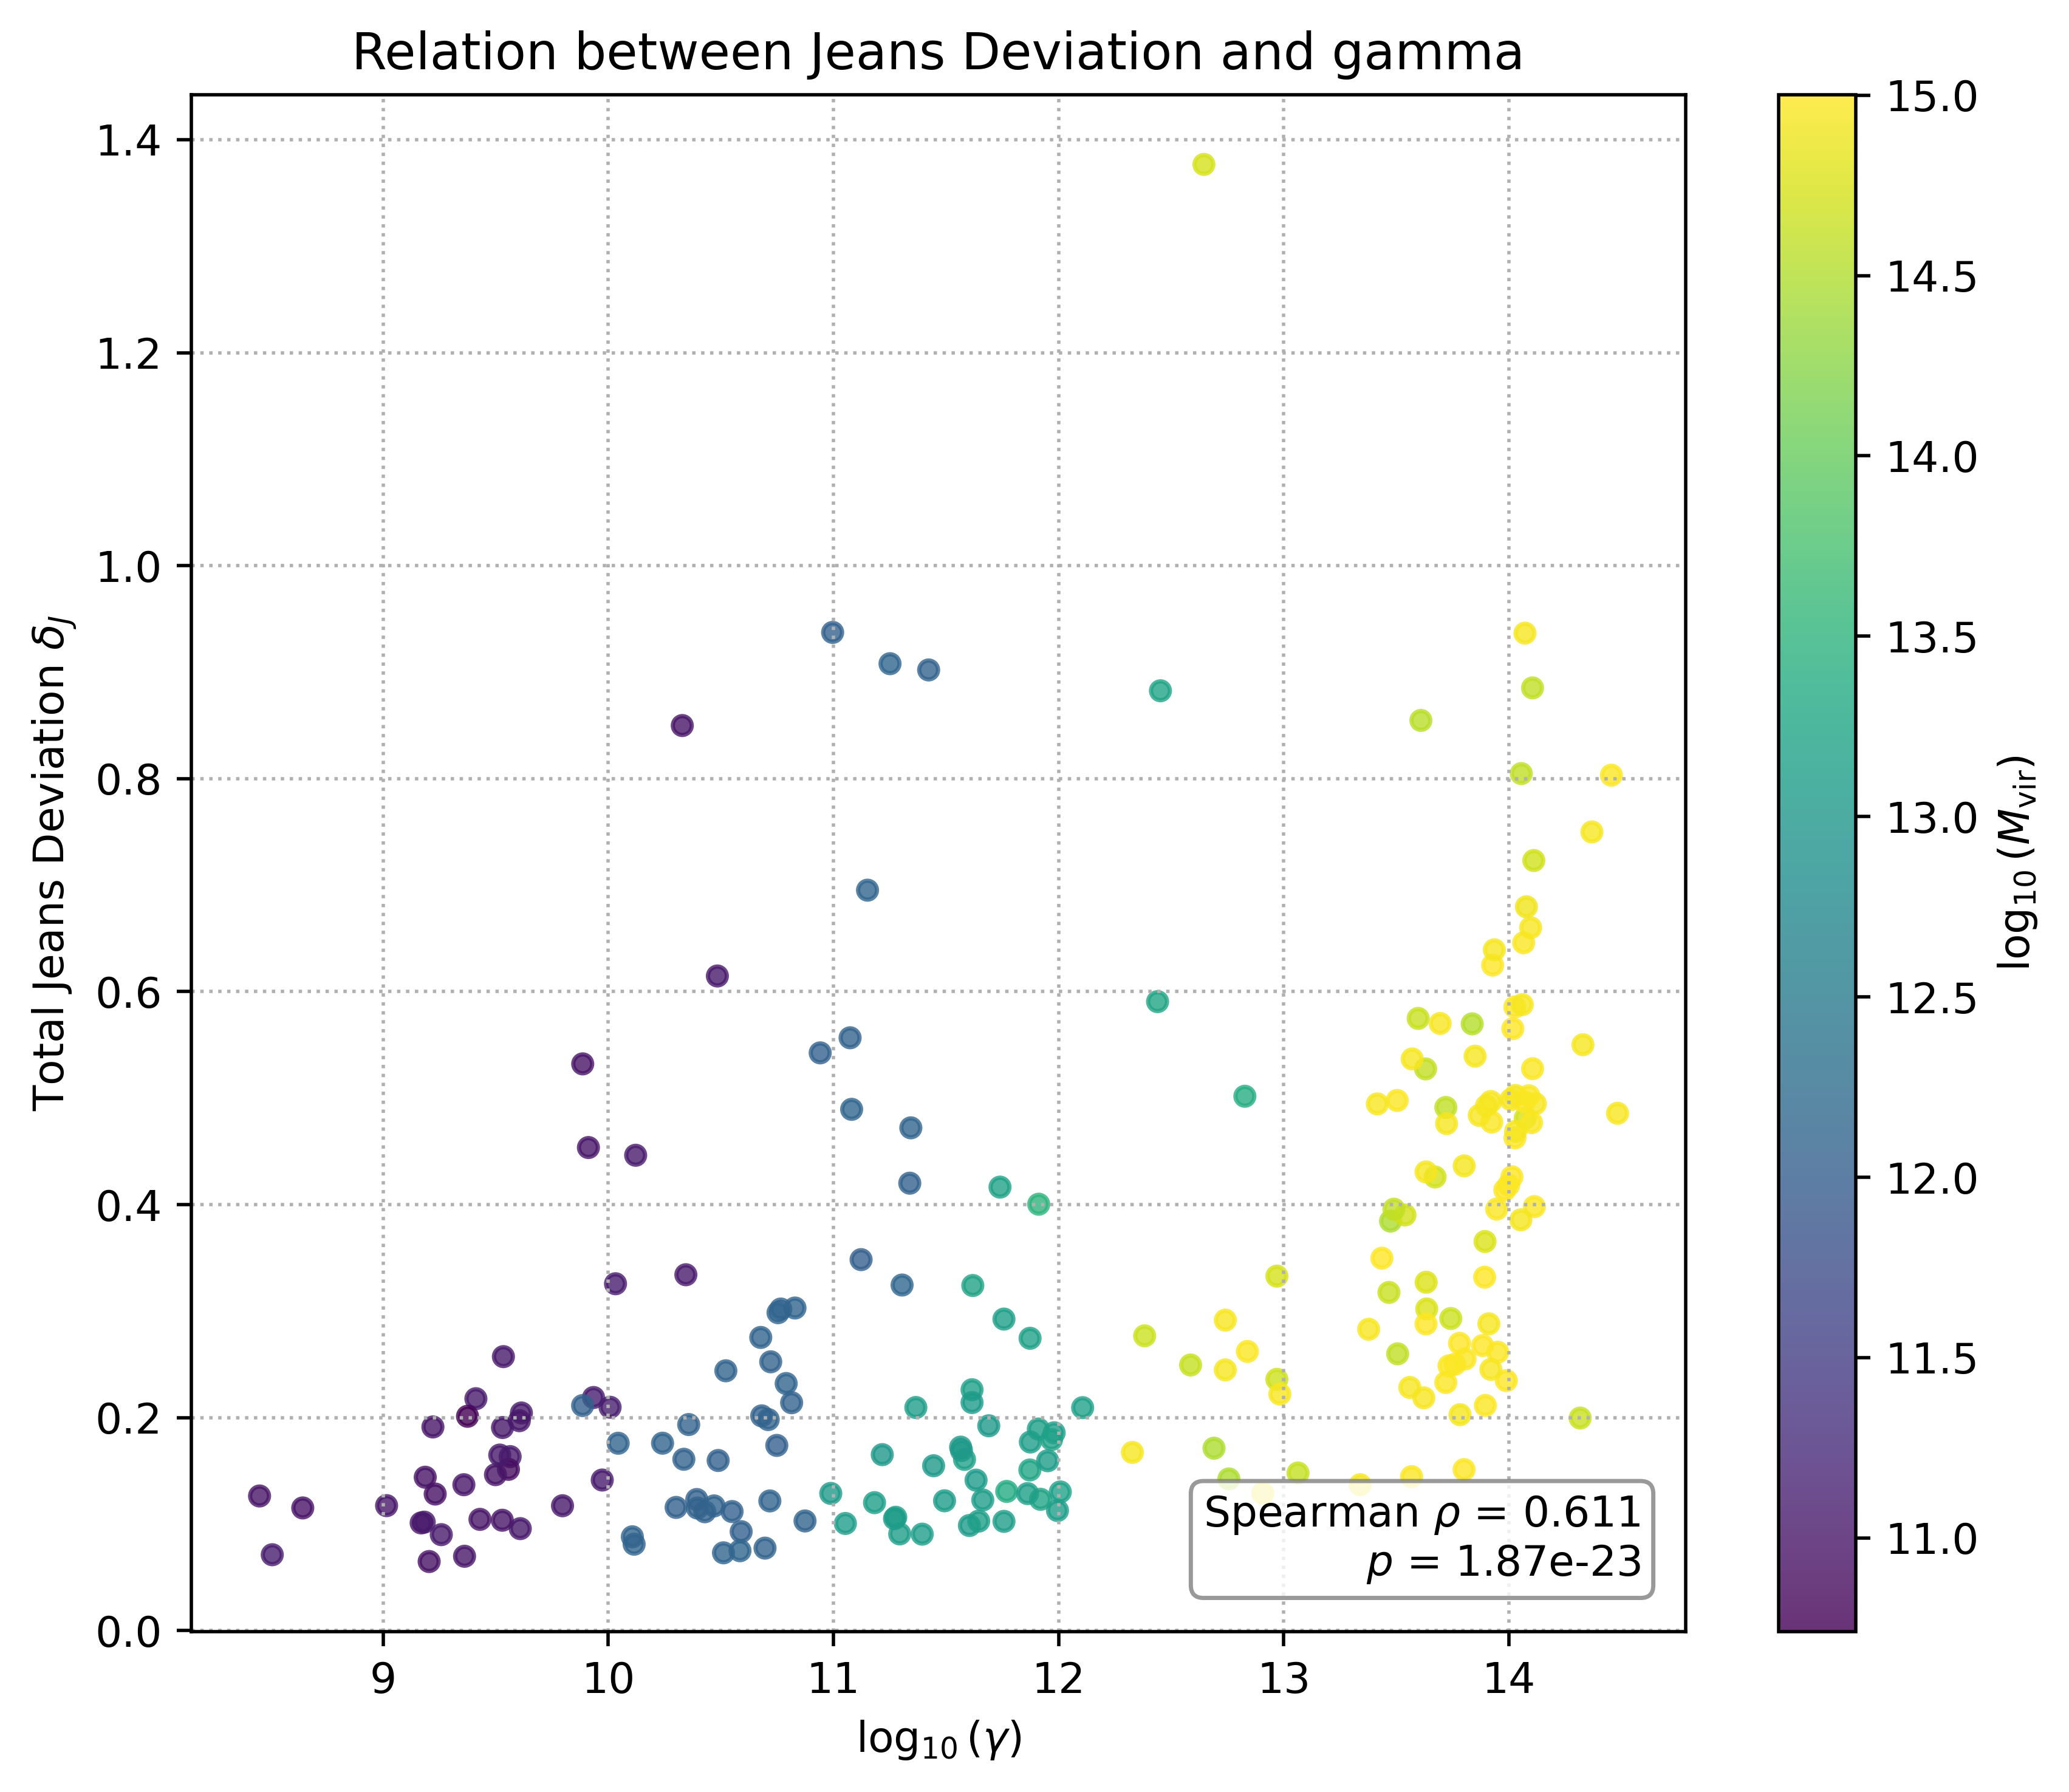

[Result] Spearman ρ = -0.229, p = 4.00e-04


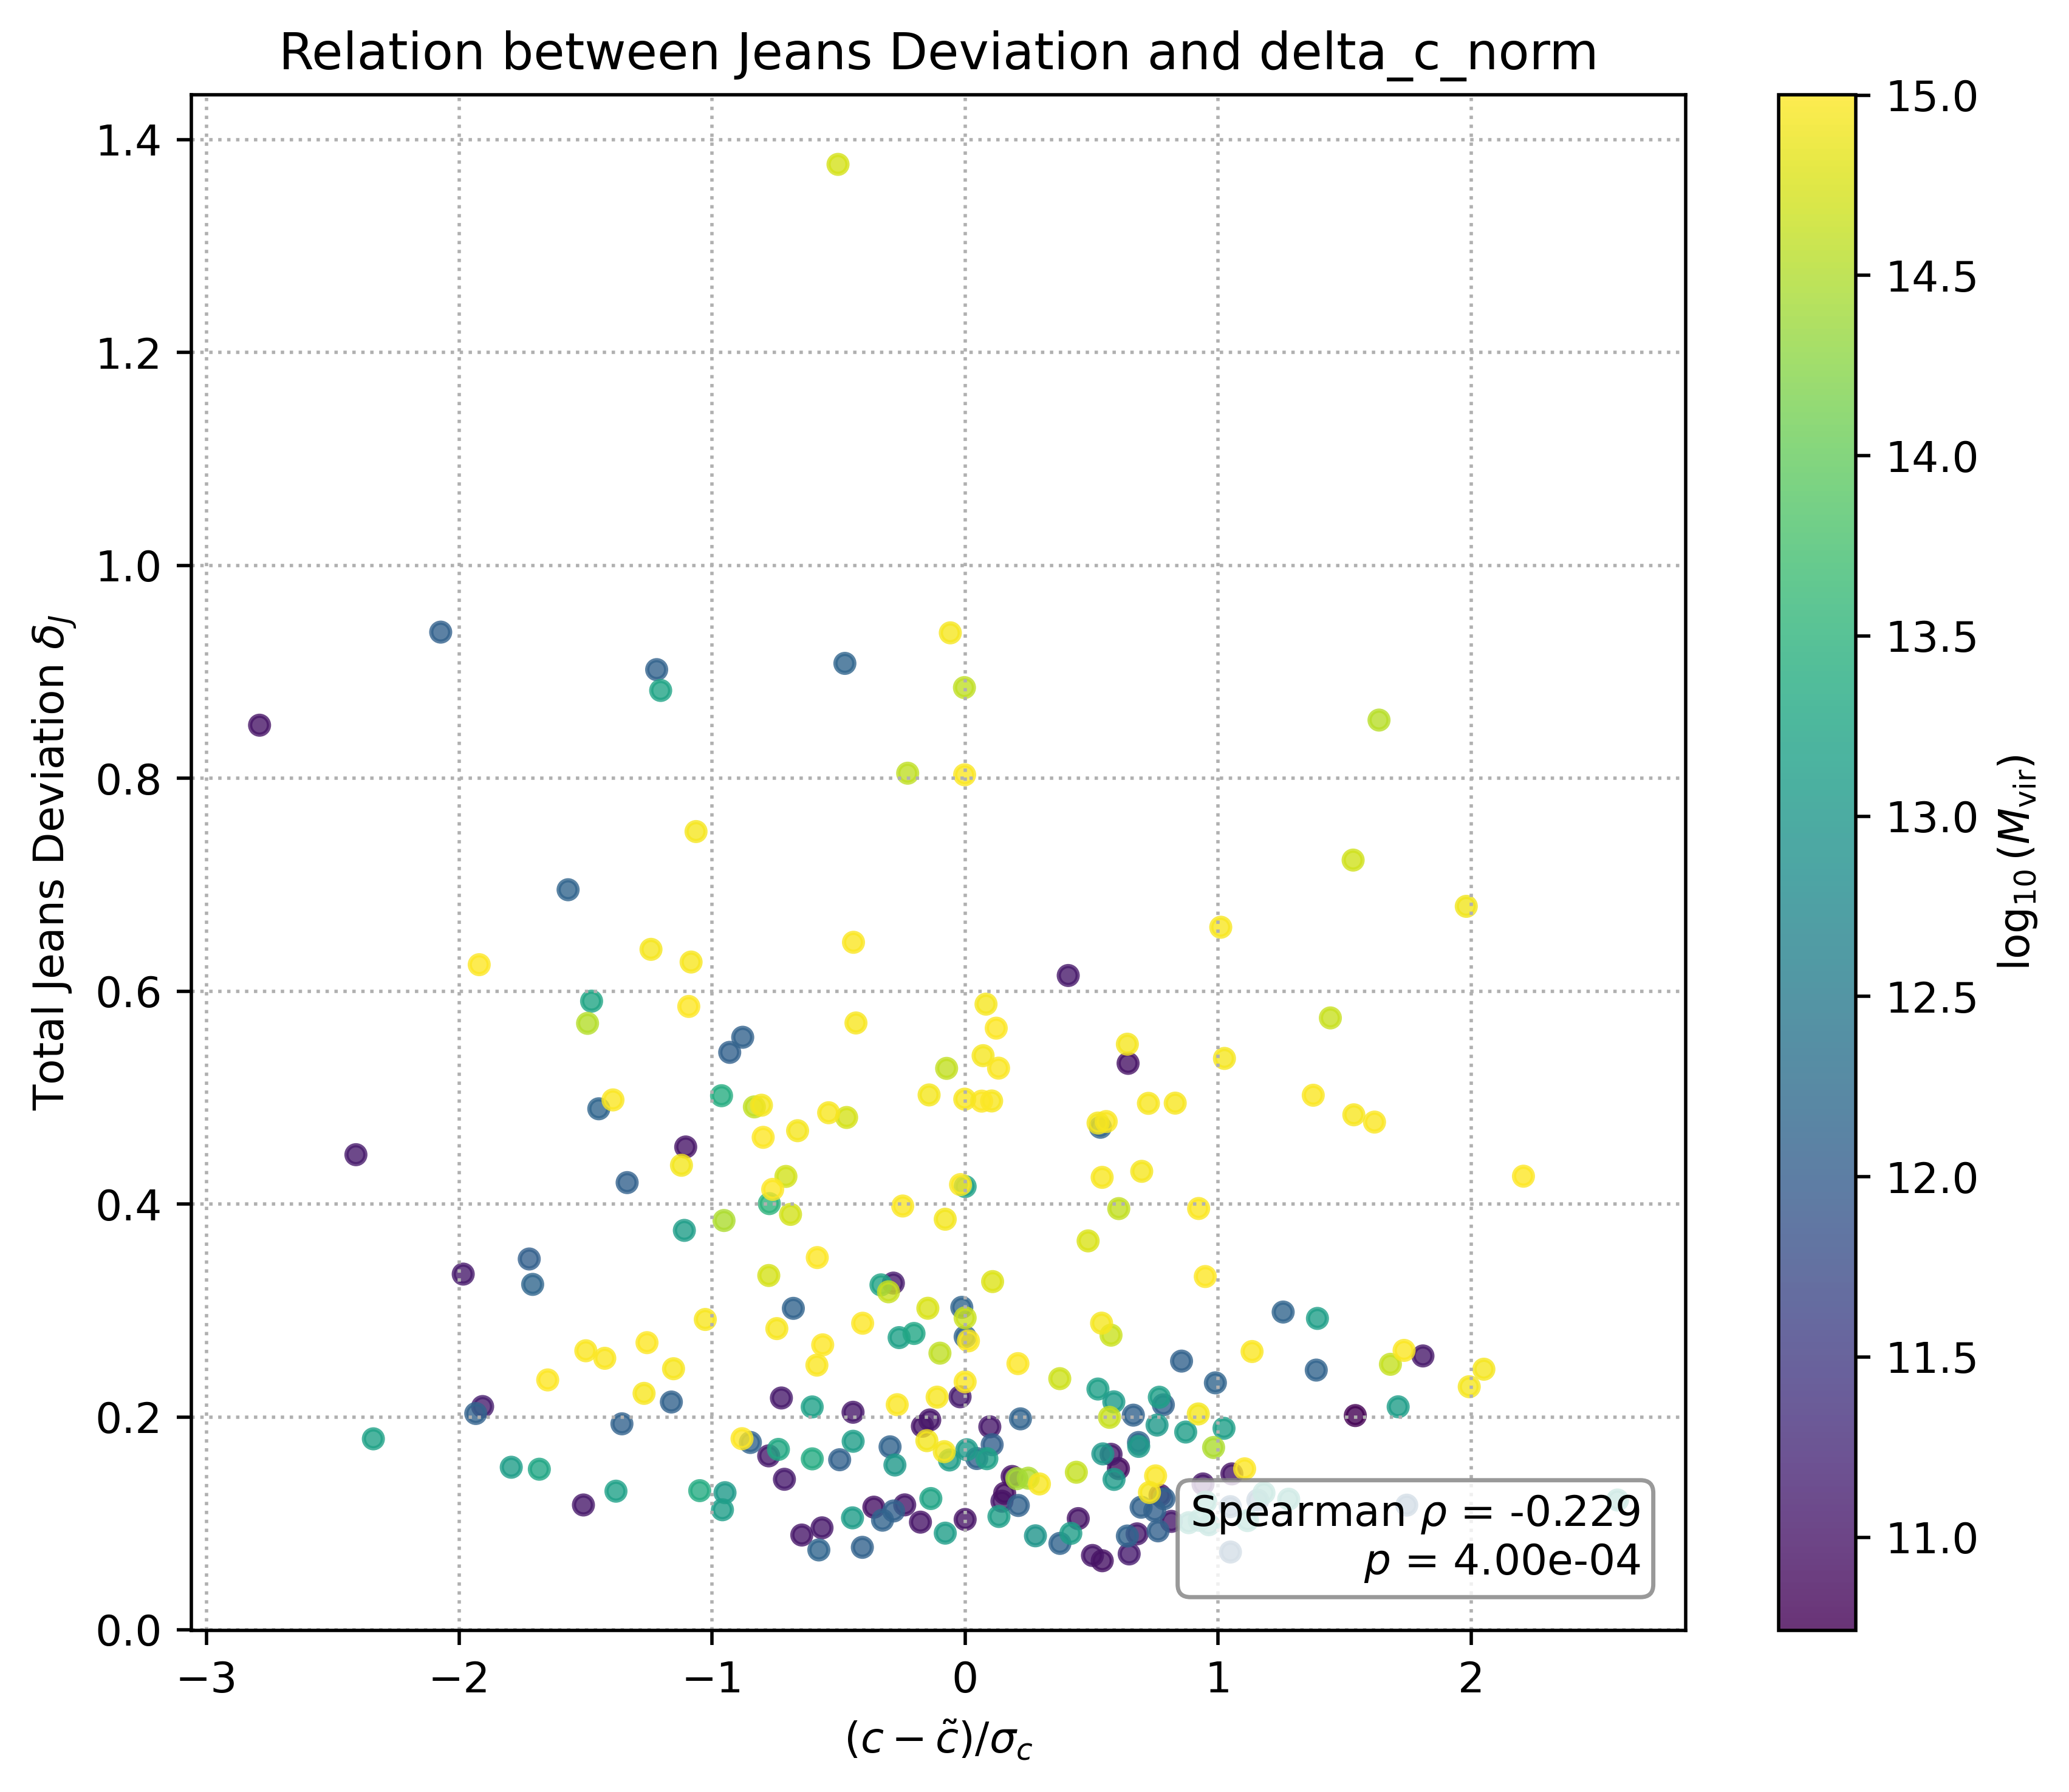

[Result] Spearman ρ = 0.501, p = 4.20e-15


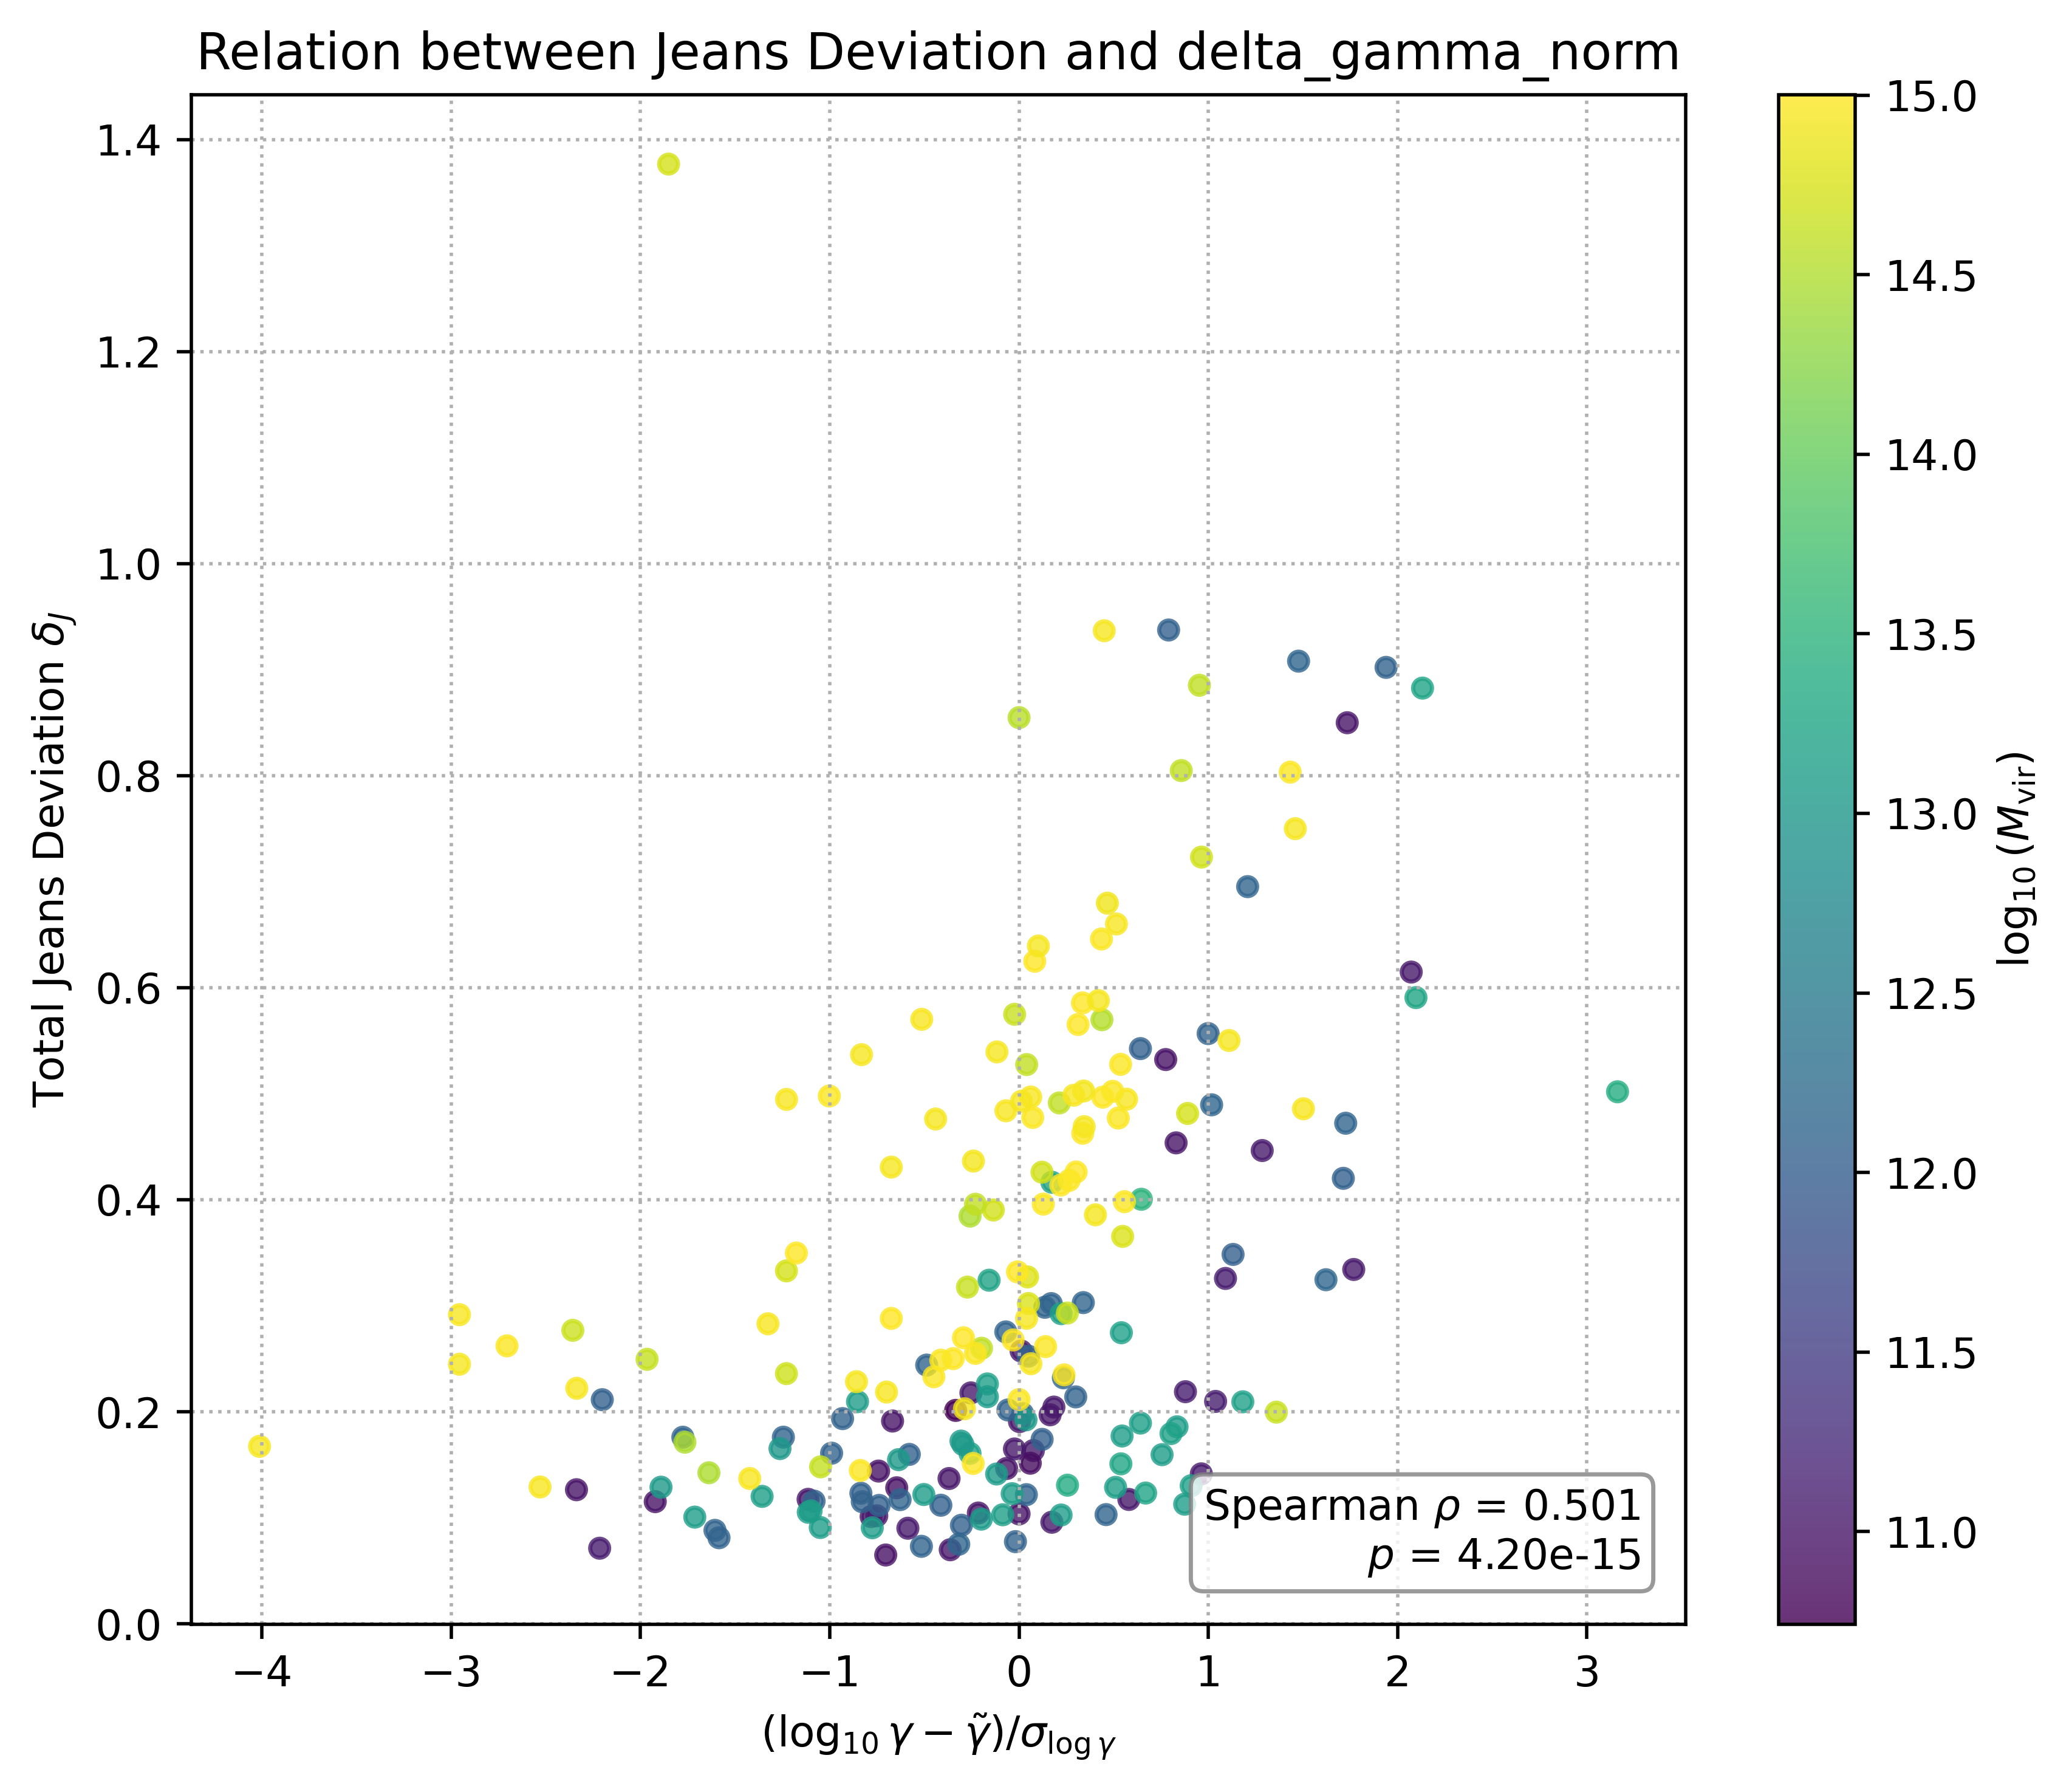

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def quantify_jeans_vs_cgamma(base_dir, suite_names, x_var="cvir"):
    x_vals, delta_j_vals, mass_vals = [], [], []

    for suite in suite_names:
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")
        jeans_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        df_mass = pd.read_csv(mass_path)
        df_jeans = pd.read_csv(jeans_path)

        # Create lookup dictionaries
        cvir_dict = dict(zip(df_cvir["halo_id"], pd.to_numeric(df_cvir["cvir"], errors='coerce')))
        gamma_dict = dict(zip(df_gamma["halo_index"], pd.to_numeric(df_gamma["gamma"], errors='coerce')))
        mass_dict = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))
        delta_j_dict = dict(zip(df_jeans["halo_id"], pd.to_numeric(df_jeans["delta_J_tot"], errors='coerce')))

        # Normalized variables (computed within each suite)
        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_med, c_std = np.nanmedian(c_vals), np.nanstd(c_vals)
            x_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            vals = df_gamma["gamma"].values
            valid_mask = (vals > 0) & np.isfinite(vals)
            log_vals = np.log10(vals[valid_mask])
            g_med, g_std = np.nanmedian(log_vals), np.nanstd(log_vals)
            x_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - g_med) / g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        # Loop over halos
        for halo_id in delta_j_dict:
            delta_j = delta_j_dict.get(halo_id)
            mass = mass_dict.get(halo_id, np.nan)

            if x_var == "cvir":
                x = cvir_dict.get(halo_id)
            elif x_var == "gamma":
                x = gamma_dict.get(halo_id)
                x = np.log10(x) if x is not None and x > 0 else np.nan
            elif x_var in ["delta_c_norm", "delta_gamma_norm"]:
                x = x_dict.get(halo_id)
            else:
                continue

            x = pd.to_numeric(x, errors='coerce')
            delta_j = pd.to_numeric(delta_j, errors='coerce')
            if np.isfinite(x) and np.isfinite(delta_j):
                x_vals.append(x)
                delta_j_vals.append(delta_j)
                mass_vals.append(mass)

    x_vals = np.array(x_vals)
    delta_j_vals = np.array(delta_j_vals)
    mass_vals = np.array(mass_vals)

    if len(x_vals) < 2:
        print("[Warning] Not enough valid data.")
        return

    log_mass = np.log10(mass_vals)
    spearman_r, spearman_p = spearmanr(x_vals, delta_j_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(x_vals, delta_j_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8)
    plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir})$")
    plt.grid(True, linestyle=":")
    plt.xlabel({
        "cvir": r"$c_{\rm vir}$",
        "gamma": r"$\log_{10}(\gamma)$",
        "delta_c_norm": r"$(c - \tilde{c})/\sigma_c$",
        "delta_gamma_norm": r"$(\log_{10} \gamma - \tilde{\gamma})/\sigma_{\log \gamma}$"
    }.get(x_var, x_var))
    plt.ylabel(r"Total Jeans Deviation $\delta_J$")
    plt.title("Relation between Jeans Deviation and " + x_var)
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}",
        rf"$p$ = {spearman_p:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"[Result] Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]

quantify_jeans_vs_cgamma(base_dir, suite_names, x_var="cvir")
quantify_jeans_vs_cgamma(base_dir, suite_names, x_var="gamma")
quantify_jeans_vs_cgamma(base_dir, suite_names, x_var="delta_c_norm")
quantify_jeans_vs_cgamma(base_dir, suite_names, x_var="delta_gamma_norm")